In [276]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler  # стандартизация данных
from sklearn.preprocessing import MinMaxScaler    # масштабирование MinMaxScaler
from sklearn.preprocessing import Normalizer      # масштабирование Normalizer

from scipy.stats import shapiro, normaltest, ttest_rel, ttest_ind, kstest   # тесты на норм. распределение данных
import warnings
warnings.simplefilter('ignore')
from scipy.stats import ks_2samp, chi2_contingency   # двухсторонняя гипотеза (двухвыборочный тест)

from sklearn.model_selection import train_test_split   # разделение выборки на train и test
from sklearn.metrics import r2_score, classification_report, f1_score, precision_score, recall_score # метрики

from sklearn.ensemble import RandomForestRegressor      # модели регрессии для восполнения неточностей в данных
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.linear_model import LogisticRegression     # модели классификации
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import VotingClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.model_selection import cross_val_score     # кросс-валидация
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV  # подбор гиперпараметров

from sklearn.decomposition import PCA   # метод главных компонент

In [277]:
# пути расположения выборок
path_train = '/home/tefi/Homework/Project/course_project_train.csv'
path_test = '/home/tefi/Homework/Project/course_project_test.csv'

In [278]:
# загрузка данных из файлов в соответствующие переменные
train = pd.read_csv(path_train)
test = pd.read_csv(path_test) 

Описание датасета:
Home Ownership - домовладение
Annual Income - годовой доход
Years in current job - количество лет на текущем месте работы
Tax Liens - налоговые обременения
Number of Open Accounts - количество открытых счетов
Years of Credit History - количество лет кредитной истории
Maximum Open Credit - наибольший открытый кредит
Number of Credit Problems - количество проблем с кредитом
Months since last delinquent - количество месяцев с последней просрочки платежа
Bankruptcies - банкротства
Purpose - цель кредита
Term - срок кредита
Current Loan Amount - текущая сумма кредита
Current Credit Balance - текущий кредитный баланс
Monthly Debt - ежемесячный долг
Credit Score - кредитный рейтинг (“Баллы Доверия”) это трехзначное число в диапазоне от 300 до 900
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [279]:
train_data = train.copy()
train_data = train_data.drop(['Credit Default'], axis ='columns')  # тренировочные данные без целевой переменной
train_target = train.copy()
train_target = train['Credit Default']                             # целевая переменная для тренировочных данных
test_data = test.copy()                                            # тестовые данные

In [280]:
train_data.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0


In [281]:
train_target.head(2)

0    0
1    1
Name: Credit Default, dtype: int64

In [282]:
test_data.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


In [283]:
# оценка данных в целевой переменной: кол-во исследований соответствует train - коррекция не требуется
train_target.shape

(7500,)

In [284]:
train_target.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [285]:
# оценка тренировочных и тестовых данных, кол-во признаков совпадает - коррекция не требуется
train_data.shape

(7500, 16)

In [286]:
test_data.shape

(2500, 16)

In [287]:
# Приведение типов к необходимым
train_data.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [288]:
# 'Years in current job' - необходимо перевести в числовой тип
train_data['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [289]:
train_data.loc[(train_data['Years in current job']=='< 1 year'), 'Years in current job'] = 0
train_data.loc[(train_data['Years in current job']=='1 year'), 'Years in current job'] = 1
train_data.loc[(train_data['Years in current job']=='2 years'), 'Years in current job'] = 2
train_data.loc[(train_data['Years in current job']=='3 years'), 'Years in current job'] = 3
train_data.loc[(train_data['Years in current job']=='4 years'), 'Years in current job'] = 4
train_data.loc[(train_data['Years in current job']=='5 years'), 'Years in current job'] = 5
train_data.loc[(train_data['Years in current job']=='6 years'), 'Years in current job'] = 6
train_data.loc[(train_data['Years in current job']=='7 years'), 'Years in current job'] = 7
train_data.loc[(train_data['Years in current job']=='8 years'), 'Years in current job'] = 8
train_data.loc[(train_data['Years in current job']=='9 years'), 'Years in current job'] = 9
train_data.loc[(train_data['Years in current job']=='10+ years'), 'Years in current job'] = 10

In [290]:
train_data['Years in current job'] = train_data['Years in current job'].astype(float)
train_data['Years in current job'].value_counts()

10.0    2332
2.0      705
3.0      620
0.0      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64

In [291]:
# тоже самое повторяем для тестовой выборки
test_data.loc[(test_data['Years in current job']=='< 1 year'), 'Years in current job'] = 0
test_data.loc[(test_data['Years in current job']=='1 year'), 'Years in current job'] = 1
test_data.loc[(test_data['Years in current job']=='2 years'), 'Years in current job'] = 2
test_data.loc[(test_data['Years in current job']=='3 years'), 'Years in current job'] = 3
test_data.loc[(test_data['Years in current job']=='4 years'), 'Years in current job'] = 4
test_data.loc[(test_data['Years in current job']=='5 years'), 'Years in current job'] = 5
test_data.loc[(test_data['Years in current job']=='6 years'), 'Years in current job'] = 6
test_data.loc[(test_data['Years in current job']=='7 years'), 'Years in current job'] = 7
test_data.loc[(test_data['Years in current job']=='8 years'), 'Years in current job'] = 8
test_data.loc[(test_data['Years in current job']=='9 years'), 'Years in current job'] = 9
test_data.loc[(test_data['Years in current job']=='10+ years'), 'Years in current job'] = 10
test_data['Years in current job'] = test_data['Years in current job'].astype(float)
test_data.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [292]:
# анализ данных показывает, что текущая сумма кредита не всегда больше текущего кредитного баланса, 
# что логически неверно. Вероятнее всего, что эти цифры перепутаны местами
train_data.loc[(train_data['Current Loan Amount'] < train_data['Current Credit Balance'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0
13,Rent,2066364.0,10.0,0.0,11.0,17.7,1654026.0,0.0,NaN,0.0,debt consolidation,Long Term,549780.0,1037077.0,21869.0,728.0
14,Own Home,2258796.0,7.0,0.0,11.0,17.7,1602546.0,0.0,NaN,0.0,other,Short Term,185262.0,1374327.0,58352.0,748.0
16,Rent,NaN,7.0,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN
17,Home Mortgage,3361898.0,3.0,0.0,14.0,28.5,1042096.0,0.0,NaN,0.0,debt consolidation,Long Term,498872.0,689396.0,52249.0,644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7479,Own Home,1721932.0,10.0,0.0,9.0,28.0,912142.0,0.0,NaN,0.0,debt consolidation,Short Term,105490.0,723957.0,37022.0,739.0
7482,Home Mortgage,NaN,10.0,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN
7486,Rent,5327372.0,1.0,0.0,7.0,12.1,605638.0,0.0,NaN,0.0,debt consolidation,Short Term,111760.0,292904.0,8080.0,750.0
7496,Home Mortgage,1533984.0,1.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0


In [293]:
train_data.loc[(train_data['Current Loan Amount'] < train_data['Current Credit Balance']), ['Current Loan Amount']] = train['Current Credit Balance']

In [294]:
train_data.loc[(train_data['Current Loan Amount'] == train_data['Current Credit Balance']), ['Current Credit Balance']] = train['Current Loan Amount']

In [295]:
train_data.loc[(train_data['Current Loan Amount'] < train_data['Current Credit Balance'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


In [296]:
train_data.loc[(train_data.index == 13)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
13,Rent,2066364.0,10.0,0.0,11.0,17.7,1654026.0,0.0,NaN,0.0,debt consolidation,Long Term,1037077.0,549780.0,21869.0,728.0


In [297]:
test_data.loc[(test_data['Current Loan Amount'] < test_data['Current Credit Balance'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
5,Home Mortgage,922583.0,5.0,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
8,Rent,NaN,5.0,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
12,Home Mortgage,1054614.0,2.0,0.0,11.0,14.0,306328.0,0.0,69.0,0.0,debt consolidation,Short Term,155408.0,202388.0,14940.0,7030.0
13,Rent,1232530.0,3.0,0.0,15.0,14.7,441518.0,0.0,NaN,0.0,debt consolidation,Short Term,210782.0,228399.0,29889.0,720.0
15,Rent,1118302.0,10.0,0.0,16.0,27.1,676720.0,0.0,NaN,0.0,debt consolidation,Short Term,372834.0,506103.0,23671.0,711.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,Home Mortgage,NaN,10.0,0.0,24.0,36.6,3341228.0,0.0,NaN,0.0,debt consolidation,Short Term,455950.0,1255235.0,44682.0,NaN
2489,Own Home,950589.0,6.0,0.0,9.0,21.3,611182.0,0.0,NaN,0.0,debt consolidation,Short Term,258984.0,360525.0,11724.0,740.0
2496,Home Mortgage,NaN,2.0,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2.0,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0


In [298]:
test_data.loc[(test_data['Current Loan Amount'] < test_data['Current Credit Balance']), ['Current Loan Amount']] = test['Current Credit Balance']

In [299]:
test_data.loc[(test_data['Current Loan Amount'] == test_data['Current Credit Balance']), ['Current Credit Balance']] = test['Current Loan Amount']

In [300]:
test_data.loc[(test_data['Current Loan Amount'] < test_data['Current Credit Balance'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


In [301]:
# обработка выбросов
train_data.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7129.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,5.880348,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.193994e+07,2.230703e+05,18314.454133,1151.087498
std,8.453392e+05,3.620092,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.190275e+07,1.931518e+05,11926.764673,1604.451418
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,2.198240e+05,1.016025e+05,10067.500000,711.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.497010e+05,1.785850e+05,16076.500000,731.000000
75%,1.640137e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,6.074922e+05,2.967198e+05,23818.000000,743.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,4.249673e+06,136679.000000,7510.000000


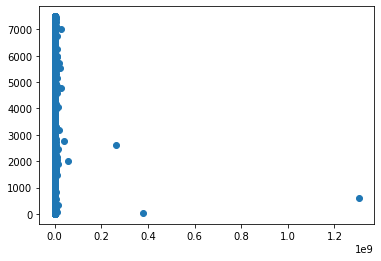

In [302]:
# явный выброс
plt.scatter(train_data['Maximum Open Credit'], train_data.index)

In [303]:
train_data.loc[(train_data['Maximum Open Credit'] == train_data['Maximum Open Credit'].max(), ['Maximum Open Credit'])] = train_data['Current Loan Amount']

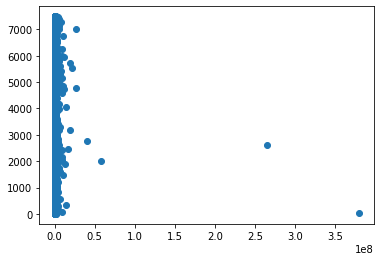

In [304]:
plt.scatter(train_data['Maximum Open Credit'], train_data.index)

In [305]:
# тоже явный выброс
train_data.loc[(train_data['Maximum Open Credit'] == train_data['Maximum Open Credit'].max())]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
44,Have Mortgage,1334256.0,10.0,0.0,17.0,15.4,380052288.0,1.0,35.0,0.0,take a trip,Short Term,656450.0,33110.0,34357.0,729.0


In [306]:
train_data.loc[(train_data['Maximum Open Credit'] == train_data['Maximum Open Credit'].max(), ['Maximum Open Credit'])] = train_data['Current Loan Amount']

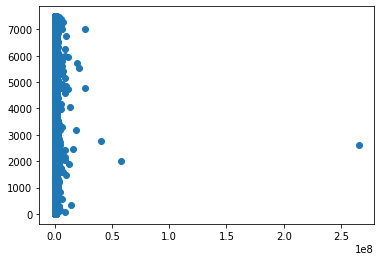

In [307]:
plt.scatter(train_data['Maximum Open Credit'], train_data.index)

In [308]:
# выброс
train_data.loc[(train_data['Maximum Open Credit'] == train_data['Maximum Open Credit'].max())]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2617,Home Mortgage,3217802.0,10.0,0.0,12.0,35.5,265512874.0,0.0,NaN,0.0,other,Short Term,1834450.0,50116.0,20272.0,750.0


In [309]:
train_data.loc[(train_data['Maximum Open Credit'] == train_data['Maximum Open Credit'].max(), ['Maximum Open Credit'])] = train_data['Current Loan Amount']

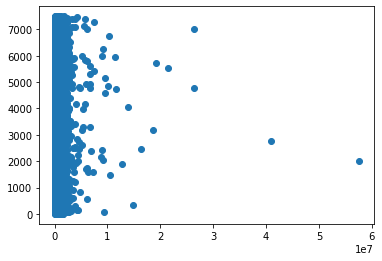

In [310]:
plt.scatter(train_data['Maximum Open Credit'], train_data.index)

In [311]:
# дальнейшие максимальные значения нельзя однозначно признать выбросами
train_data.loc[(train_data['Maximum Open Credit'] == train_data['Maximum Open Credit'].max())]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2023,Rent,1342825.0,10.0,0.0,12.0,16.3,57562560.0,0.0,NaN,0.0,other,Short Term,944547.0,166826.0,9176.0,749.0


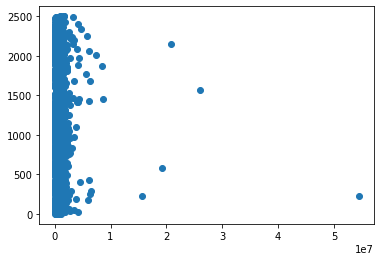

In [312]:
# проверяем тестовую выборку - явных выбросов нет
plt.scatter(test_data['Maximum Open Credit'], test_data.index)

In [313]:
test_data.loc[(test_data['Maximum Open Credit'] == test_data['Maximum Open Credit'].max())]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
228,Home Mortgage,3356255.0,10.0,0.0,20.0,17.2,54484386.0,0.0,NaN,0.0,home improvements,Long Term,5176018.0,777238.0,42792.0,695.0


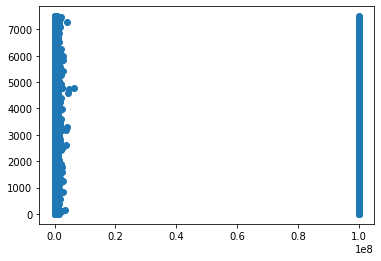

In [314]:
# явные выбросы - обработаем их методом регресии
plt.scatter(train_data['Current Loan Amount'], train_data.index)

In [315]:
train_data.loc[(train_data['Current Loan Amount'] == train_data['Current Loan Amount'].max())].head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0
6,Home Mortgage,1511108.0,10.0,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0


In [316]:
train_data.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [317]:
train_data.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
dtype: int64

In [318]:
# создадим датафрейм, содержащий только исследования с выбросами
train_data_reg_neg = train_data.loc[(train_data['Current Loan Amount'] == train_data['Current Loan Amount'].max())]
# вырежем из него строковые признаки, признаки, содержащие null-значения, и признак-предсказание
train_data_reg_neg_x = train_data_reg_neg.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income', 
                                              'Years in current job', 'Months since last delinquent', 
                                              'Bankruptcies', 'Credit Score', 'Current Loan Amount'], 
                                             axis ='columns')
train_data_reg_neg_x.head(2)

,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Current Credit Balance,Monthly Debt
0,0.0,11.0,26.3,685960.0,1.0,47386.0,7914.0
2,0.0,11.0,35.0,1182434.0,0.0,308389.0,13651.0


In [319]:
# создадим датафрейм, содержащий только исследования без выбросов
train_data_reg_pos = train_data.loc[(train_data['Current Loan Amount'] != train_data['Current Loan Amount'].max())]
# вырежем из него строковые признаки, признаки, содержащие null-значения, и признак-предсказание
train_data_reg_pos_x = train_data_reg_pos.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income', 
                                              'Years in current job', 'Months since last delinquent', 
                                              'Bankruptcies', 'Credit Score', 'Current Loan Amount'], 
                                             axis ='columns')
train_data_reg_pos_y = train_data_reg_pos['Current Loan Amount']
train_data_reg_pos_x.head(2)

,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Current Credit Balance,Monthly Debt
1,0.0,15.0,15.3,1181730.0,0.0,264968.0,18373.0
3,0.0,8.0,22.5,147400.0,1.0,95855.0,11338.0


In [320]:
train_data_reg_pos_y.head(2)

1    394972.0
3    121396.0
Name: Current Loan Amount, dtype: float64

In [321]:
# проверяем кол-во сторок и столбцов на совпадение
train_data_reg_neg_x.shape

(870, 7)

In [322]:
train_data_reg_pos_x.shape

(6630, 7)

In [323]:
train_data_reg_pos_y.shape

(6630,)

In [324]:
# стандартизируем данные, по тестовой переменной без fit (обучения)
scaler_1 = StandardScaler()
train_data_reg_pos_x_st = pd.DataFrame(scaler_1.fit_transform(train_data_reg_pos_x), columns=train_data_reg_pos_x.columns)
train_data_reg_neg_x_st = pd.DataFrame(scaler_1.transform(train_data_reg_neg_x), columns=train_data_reg_neg_x.columns)
train_data_reg_pos_x_st.head(2)

,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Current Credit Balance,Monthly Debt
0,-0.113199,0.786070,-0.424812,0.466046,-0.341087,0.335583,0.000715
1,-0.113199,-0.635934,0.597352,-0.468063,1.647837,-0.748124,-0.591412


In [325]:
# делим выборки на train и test
x_train, x_test, y_train, y_test = train_test_split(train_data_reg_pos_x_st, train_data_reg_pos_y, test_size=0.30)

In [326]:
# создаем модели
rfr = RandomForestRegressor(n_estimators=1000, max_depth=18, min_samples_leaf=20, random_state=42)
lgb = LGBMRegressor(max_depth=30, min_samples_leaf=10, n_estimators=1000, random_state=42)
boost = GradientBoostingRegressor(n_estimators=600, max_depth=4, min_samples_split=12,
                                           learning_rate=0.1, loss='ls', random_state=42)
voting= VotingRegressor([('rfr', rfr), ('boost', boost), ('lgb', lgb)])

In [327]:
# обучаем модели (перед добавлением в voting, добиваемся наилучших показателей по каждой из моделей)

#rfr.fit(x_train, y_train)
#lgb.fit(x_train, y_train)
#boost.fit(x_train, y_train)
voting.fit(x_train, y_train)

VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(max_depth=18,
                                                   min_samples_leaf=20,
                                                   n_estimators=1000,
                                                   random_state=42)),
                            ('boost',
                             GradientBoostingRegressor(max_depth=4,
                                                       min_samples_split=12,
                                                       n_estimators=600,
                                                       random_state=42)),
                            ('lgb',
                             LGBMRegressor(max_depth=30, min_samples_leaf=10,
                                           n_estimators=1000,
                                           random_state=42))])

In [328]:
# предсказываем целевую переменную
y_pred = voting.predict(x_test)

In [329]:
# объединяем данные (проверочная и предсказанная целевая переменная)
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),})
check_test.head(2)

,y_test,y_pred
7399,439560.0,241979.304872
2895,479952.0,388305.181749


In [330]:
# определяем качество модели по метрике r2
r2 = r2_score(check_test["y_test"], check_test["y_pred"])
r2

0.5953883609697627

In [331]:
# предсказываем необходимые значения и собираем их в переменную с соответствующими индексами
y_pred_neg_null = voting.predict(train_data_reg_neg_x_st)
current_loan = pd.DataFrame({
    "Id": train_data_reg_neg_x.index,
    "Current Loan Amount": y_pred_neg_null})
current_loan.head(2)

,Id,Current Loan Amount
0,0,240895.726264
1,2,508727.942520


In [332]:
# в основных train данных нет признака "Id", он необходим оля объединения с датафреймом предсказанных значений,
train_data.head(4)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,394972.0,264968.0,18373.0,737.0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0


In [333]:
# создаем признак "Id" равный индексам
train_data['Id'] = train_data.index

In [334]:
# объединяем по признаку "Id" предсказанный датафрейм и основной датафрейм
train_data = pd.merge(train_data, current_loan, on='Id', how='left')
train_data.head(4)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount_x,Current Credit Balance,Monthly Debt,Credit Score,Id,Current Loan Amount_y
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,240895.726264
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,394972.0,264968.0,18373.0,737.0,1,NaN
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,2,508727.942520
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,3,NaN


In [335]:
# заменяем в признаке основного датафрейма выбросы на предсказанные значения
train_data.loc[(train_data['Current Loan Amount_x'] == train_data['Current Loan Amount_x'].max()), ['Current Loan Amount_x']] = train_data['Current Loan Amount_y']
train_data.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount_x,Current Credit Balance,Monthly Debt,Credit Score,Id,Current Loan Amount_y
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,240895.726264,47386.0,7914.0,749.0,0,240895.726264
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,394972.000000,264968.0,18373.0,737.0,1,NaN


In [336]:
# удаляем предсказонные значения и сливные значения из основного датафрейма
train_data = train_data.drop(['Current Loan Amount_y', 'Id'], axis ='columns')
train_data.head(4)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount_x,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,240895.726264,47386.0,7914.0,749.0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,394972.000000,264968.0,18373.0,737.0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,508727.942520,308389.0,13651.0,742.0
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0


In [337]:
# переименовываем столбец в изначальное название
train_data.rename(columns={'Current Loan Amount_x': 'Current Loan Amount'}, inplace=True)
train_data.head(4)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,240895.726264,47386.0,7914.0,749.0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,394972.000000,264968.0,18373.0,737.0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,508727.942520,308389.0,13651.0,742.0
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0


In [338]:
# проверяем данные на неизменность строк и столбцов
train_data.shape

(7500, 16)

In [339]:
# после заполнения выбросов регрессией, у нас появилось несколько  исследований в которых 
# сумма текущего кредита меньше оставшегося баланса
train_data.loc[(train_data['Current Loan Amount'] < train_data['Current Credit Balance'])].head(4)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
604,Home Mortgage,2822773.0,1.0,0.0,13.0,29.5,3409934.0,0.0,NaN,0.0,debt consolidation,Short Term,2.459548e+06,2612177.0,50810.0,727.0
740,Home Mortgage,2506917.0,10.0,0.0,16.0,21.4,1720620.0,0.0,NaN,0.0,small business,Short Term,1.086055e+06,1124895.0,37604.0,712.0
1334,Home Mortgage,1841157.0,7.0,0.0,17.0,24.5,1876644.0,0.0,20.0,0.0,debt consolidation,Short Term,1.154167e+06,1210680.0,43114.0,737.0
1364,Rent,2528577.0,1.0,0.0,12.0,19.1,941006.0,0.0,46.0,0.0,debt consolidation,Short Term,6.877321e+05,741988.0,36243.0,686.0


In [340]:
# выбросы текущей суммы кредита приравниваем к текущему кредитному балансу
train_data.loc[(train_data['Current Loan Amount'] < train_data['Current Credit Balance']), ['Current Loan Amount']] = train_data['Current Credit Balance']
train_data.loc[(train_data['Current Loan Amount'] < train_data['Current Credit Balance'])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


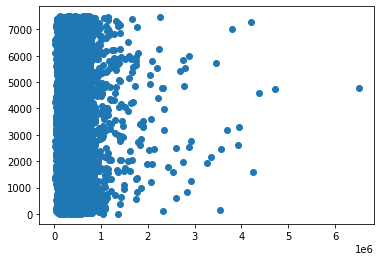

In [341]:
plt.scatter(train_data['Current Loan Amount'], train_data.index)

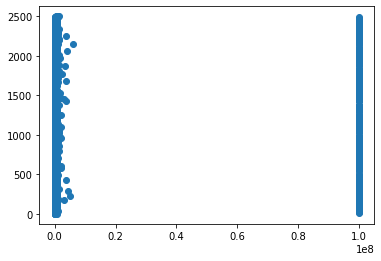

In [342]:
# повторяем тоже самое для тестовой выборки
plt.scatter(test_data['Current Loan Amount'], test_data.index)

In [343]:
test_data.loc[(test_data['Current Loan Amount'] == test_data['Current Loan Amount'].max())].head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
17,Home Mortgage,1246495.0,9.0,0.0,10.0,22.9,357456.0,0.0,40.0,0.0,debt consolidation,Short Term,99999999.0,294823.0,21086.0,729.0
22,Own Home,960735.0,8.0,0.0,17.0,11.8,512380.0,0.0,29.0,0.0,debt consolidation,Short Term,99999999.0,164179.0,17133.0,733.0
33,Rent,743888.0,1.0,0.0,11.0,20.0,927124.0,0.0,18.0,0.0,debt consolidation,Short Term,99999999.0,303468.0,15002.0,735.0


In [344]:
test_data_reg_neg = test_data.loc[(test_data['Current Loan Amount'] == test_data['Current Loan Amount'].max())]
test_data_reg_neg_x = test_data_reg_neg.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income', 
                                              'Years in current job', 'Months since last delinquent', 
                                              'Bankruptcies', 'Credit Score', 'Current Loan Amount'], 
                                             axis ='columns')
test_data_reg_pos = test_data.loc[(test_data['Current Loan Amount'] != test_data['Current Loan Amount'].max())]
test_data_reg_pos_x = test_data_reg_pos.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income', 
                                              'Years in current job', 'Months since last delinquent', 
                                              'Bankruptcies', 'Credit Score', 'Current Loan Amount'], 
                                             axis ='columns')
test_data_reg_pos_y = test_data_reg_pos['Current Loan Amount']

test_data_reg_pos_x_st = pd.DataFrame(scaler_1.fit_transform(test_data_reg_pos_x), columns=test_data_reg_pos_x.columns)
test_data_reg_neg_x_st = pd.DataFrame(scaler_1.transform(test_data_reg_neg_x), columns=test_data_reg_neg_x.columns)
x_train, x_test, y_train, y_test = train_test_split(test_data_reg_pos_x_st, test_data_reg_pos_y, test_size=0.30)


In [345]:
voting.fit(x_train, y_train)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(max_depth=18,
                                                   min_samples_leaf=20,
                                                   n_estimators=1000,
                                                   random_state=42)),
                            ('boost',
                             GradientBoostingRegressor(max_depth=4,
                                                       min_samples_split=12,
                                                       n_estimators=600,
                                                       random_state=42)),
                            ('lgb',
                             LGBMRegressor(max_depth=30, min_samples_leaf=10,
                                           n_estimators=1000,
                                           random_state=42))])

In [346]:
y_pred = voting.predict(x_test)
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),})
check_test.head(2)
r2 = r2_score(check_test["y_test"], check_test["y_pred"])
r2

0.6610098067245443

In [347]:
y_pred_neg_null = voting.predict(test_data_reg_neg_x_st)
current_loan = pd.DataFrame({
    "Id": test_data_reg_neg_x.index,
    "Current Loan Amount": y_pred_neg_null})
current_loan.head(2)

,Id,Current Loan Amount
0,17,415061.304360
1,22,288145.795357


In [348]:
test_data['Id'] = test_data.index
test_data = pd.merge(test_data, current_loan, on='Id', how='left')
test_data.loc[(test_data['Current Loan Amount_x'] == test_data['Current Loan Amount_x'].max()), ['Current Loan Amount_x']] = test_data['Current Loan Amount_y']
test_data = test_data.drop(['Current Loan Amount_y', 'Id'], axis ='columns')
test_data.rename(columns={'Current Loan Amount_x': 'Current Loan Amount'}, inplace=True)
test_data.shape

(2500, 16)

In [349]:
test_data.loc[(test_data['Current Loan Amount'] < test_data['Current Credit Balance'])].head(4)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
45,Home Mortgage,1768729.0,10.0,0.0,11.0,19.7,3462558.0,0.0,NaN,0.0,debt consolidation,Short Term,1.610229e+06,1764321.0,29184.0,737.0
222,Home Mortgage,2807535.0,10.0,0.0,12.0,19.3,15568542.0,0.0,NaN,0.0,buy house,Short Term,2.097817e+06,3240374.0,27607.0,750.0
253,Home Mortgage,3863840.0,10.0,0.0,20.0,28.6,6381078.0,0.0,5.0,0.0,debt consolidation,Long Term,3.048751e+06,4304051.0,66973.0,727.0
410,Rent,2012157.0,9.0,0.0,10.0,21.2,1516306.0,0.0,NaN,0.0,other,Short Term,7.403547e+05,1107871.0,30518.0,741.0


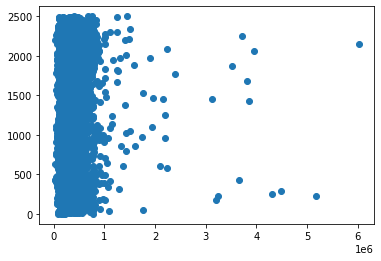

In [350]:
test_data.loc[(test_data['Current Loan Amount'] < test_data['Current Credit Balance']), ['Current Loan Amount']] = test_data['Current Credit Balance']
test_data.loc[(test_data['Current Loan Amount'] < test_data['Current Credit Balance'])]

plt.scatter(test_data['Current Loan Amount'], test_data.index)

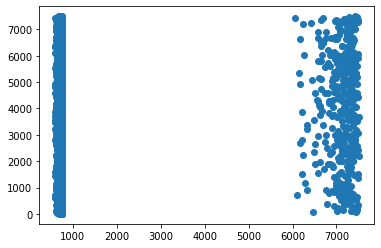

In [351]:
# Credit Score - это должно быть число от 300 до 900 => остальные значения - выбросы
plt.scatter(train_data['Credit Score'], train_data.index)

In [352]:
# наиболее вероятная причина выбросов - лишний 'нуль'.
train_data.loc[(train_data['Credit Score'] > 900)].head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
69,Home Mortgage,1408527.0,2.0,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0
87,Home Mortgage,1533566.0,7.0,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,285475.0,210826.0,18147.0,7440.0
94,Rent,1049294.0,3.0,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0


In [353]:
# заменяем выбросы Credit Score на Credit Score/10
train_data.loc[(train_data['Credit Score'] > 900), ['Credit Score']] = (train_data['Credit Score'] / 10)

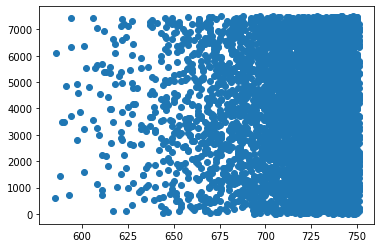

In [354]:
plt.scatter(train_data['Credit Score'], train_data.index)

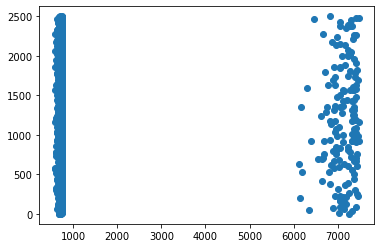

In [355]:
# повторяем для test
plt.scatter(test_data['Credit Score'], test_data.index)

In [356]:
test_data.loc[(test_data['Credit Score'] > 900)].head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2,Home Mortgage,1152540.0,3.0,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
12,Home Mortgage,1054614.0,2.0,0.0,11.0,14.0,306328.0,0.0,69.0,0.0,debt consolidation,Short Term,202388.0,155408.0,14940.0,7030.0
41,Home Mortgage,1735498.0,1.0,0.0,10.0,13.2,1584506.0,0.0,NaN,0.0,debt consolidation,Short Term,777172.0,758119.0,30371.0,7320.0


In [357]:
test_data.loc[(test_data['Credit Score'] > 900), ['Credit Score']] = (test_data['Credit Score'] / 10)

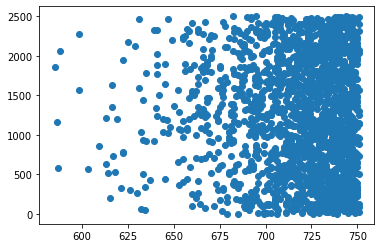

In [358]:
plt.scatter(test_data['Credit Score'], test_data.index)

In [359]:
# обработка Null значений
train_data.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
dtype: int64

In [360]:
train_data['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [361]:
# заменим null значения Bankruptcies на 0, т.к. это мода + вероятнее всего null оставляли тогда, когда 
# не было данных о банкротстве
train_data.loc[(train_data['Bankruptcies'].isnull(), ['Bankruptcies'])] = 0
test_data.loc[(test_data['Bankruptcies'].isnull(), ['Bankruptcies'])] = 0

In [362]:
train_data_reg_Annual_neg = train_data.loc[(train_data['Annual Income'].isnull())]
train_data_reg_Annual_neg_x = train_data_reg_Annual_neg.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income', 
                                                              'Years in current job', 'Months since last delinquent', 
                                                              'Credit Score'], axis ='columns')
train_data_reg_Annual_pos = train_data.loc[(train_data['Annual Income'].notnull())]
train_data_reg_Annual_pos_x = train_data_reg_Annual_pos.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income',
                                                              'Years in current job', 'Months since last delinquent', 
                                                              'Credit Score'], axis ='columns')
train_data_reg_Annual_pos_y = train_data_reg_Annual_pos['Annual Income']



test_data_reg_Annual_neg = test_data.loc[(test_data['Annual Income'].isnull())]
test_data_reg_Annual_neg_x = test_data_reg_Annual_neg.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income', 
                                                              'Years in current job', 'Months since last delinquent', 
                                                              'Credit Score'], axis ='columns')
test_data_reg_Annual_pos = test_data.loc[(test_data['Annual Income'].notnull())]
test_data_reg_Annual_pos_x = test_data_reg_Annual_pos.drop(['Home Ownership', 'Purpose', 'Term', 'Annual Income',
                                                              'Years in current job', 'Months since last delinquent', 
                                                              'Credit Score'], axis ='columns')
test_data_reg_Annual_pos_y = test_data_reg_Annual_pos['Annual Income']

In [363]:
# стандартизируем данные, по тестовой переменной без fit (обучения)
scaler_1 = StandardScaler()
train_data_reg_Annual_pos_x_st = pd.DataFrame(scaler_1.fit_transform(train_data_reg_Annual_pos_x), columns=train_data_reg_Annual_pos_x.columns)
train_data_reg_Annual_neg_x_st = pd.DataFrame(scaler_1.transform(train_data_reg_Annual_neg_x), columns=train_data_reg_Annual_neg_x.columns)

test_data_reg_Annual_pos_x_st = pd.DataFrame(scaler_1.fit_transform(test_data_reg_Annual_pos_x), columns=test_data_reg_Annual_pos_x.columns)
test_data_reg_Annual_neg_x_st = pd.DataFrame(scaler_1.transform(test_data_reg_Annual_neg_x), columns=test_data_reg_Annual_neg_x.columns)


In [364]:
# r2 = 0.409 => заменим null на регрессию
x_train, x_test, y_train, y_test = train_test_split(train_data_reg_Annual_pos_x, train_data_reg_Annual_pos_y, test_size=0.30)

boost = GradientBoostingRegressor() 
boost.fit(x_train, y_train)

y_pred = boost.predict(x_test)

check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),})
check_test.head(2)

r2 = r2_score(check_test["y_test"], check_test["y_pred"])
r2

0.39904249137676384

In [365]:
y_pred_neg_null = boost.predict(train_data_reg_Annual_neg_x)
Annual_Income = pd.DataFrame({
    "Id": train_data_reg_Annual_neg_x.index,
    "Annual Income": y_pred_neg_null})
Annual_Income.head(2)

,Id,Annual Income
0,5,1.264427e+06
1,8,8.505135e+05


In [366]:
train_data['Id'] = train_data.index
train_data = pd.merge(train_data, Annual_Income, on='Id', how='left')
train_data.head(6)

,Home Ownership,Annual Income_x,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Id,Annual Income_y
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,240895.726264,47386.0,7914.0,749.0,0,NaN
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,394972.000000,264968.0,18373.0,737.0,1,NaN
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,508727.942520,308389.0,13651.0,742.0,2,NaN
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0,3,NaN
4,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.000000,93309.0,7180.0,719.0,4,NaN
5,Rent,NaN,7.0,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.000000,165680.0,18692.0,NaN,5,1.264427e+06


In [367]:
train_data.loc[(train_data['Annual Income_x'].isnull()), ['Annual Income_x']] = train_data['Annual Income_y']
train_data.head(2)

,Home Ownership,Annual Income_x,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Id,Annual Income_y
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,240895.726264,47386.0,7914.0,749.0,0,NaN
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,394972.000000,264968.0,18373.0,737.0,1,NaN


In [368]:
train_data = train_data.drop(['Annual Income_y', 'Id'], axis ='columns')
train_data.rename(columns={'Annual Income_x': 'Annual Income'}, inplace=True)
train_data.head(4)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,240895.726264,47386.0,7914.0,749.0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,394972.000000,264968.0,18373.0,737.0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,508727.942520,308389.0,13651.0,742.0
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.000000,95855.0,11338.0,694.0


In [369]:
# остальные null значения заменим на медианы
train_data.loc[(train_data['Years in current job'].isnull(), ['Years in current job'])] = train_data['Years in current job'].median()
train_data.loc[(train_data['Months since last delinquent'].isnull(), ['Months since last delinquent'])] = train_data['Months since last delinquent'].median()
train_data.loc[(train_data['Credit Score'].isnull(), ['Credit Score'])] = train_data['Credit Score'].median()

In [370]:
train_data.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [371]:
# повторяем для test
test_data.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [372]:
x_train, x_test, y_train, y_test = train_test_split(test_data_reg_Annual_pos_x, test_data_reg_Annual_pos_y, test_size=0.30)

boost = GradientBoostingRegressor() 
boost.fit(x_train, y_train)

y_pred = boost.predict(x_test)

check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),})


y_pred_neg_null = boost.predict(test_data_reg_Annual_neg_x)
Annual_Income = pd.DataFrame({
    "Id": test_data_reg_Annual_neg_x.index,
    "Annual Income": y_pred_neg_null})
Annual_Income.head(2)


test_data['Id'] = test_data.index
test_data = pd.merge(test_data, Annual_Income, on='Id', how='left')


test_data.loc[(test_data['Annual Income_x'].isnull()), ['Annual Income_x']] = test_data['Annual Income_y']

test_data = test_data.drop(['Annual Income_y', 'Id'], axis ='columns')
test_data.rename(columns={'Annual Income_x': 'Annual Income'}, inplace=True)


test_data.loc[(test_data['Years in current job'].isnull(), ['Years in current job'])] = test_data['Years in current job'].median()
test_data.loc[(test_data['Months since last delinquent'].isnull(), ['Months since last delinquent'])] = test_data['Months since last delinquent'].median()
test_data.loc[(test_data['Credit Score'].isnull(), ['Credit Score'])] = test_data['Credit Score'].median()


In [373]:
test_data.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [374]:
# переведем значения текстовых переменных в дамми переменные
train_data.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

In [375]:
train_data['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [376]:
train_data['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [377]:
train_data['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [378]:
train_data = pd.concat([train_data, pd.get_dummies(train_data['Home Ownership'], prefix='Home Ownership')], axis=1)
train_data = pd.concat([train_data, pd.get_dummies(train_data['Purpose'], prefix='Purpose')], axis=1)
train_data = pd.concat([train_data, pd.get_dummies(train_data['Term'], prefix='Term')], axis=1)

In [379]:
train_data.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Own Home,482087.0,6.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,240895.726264,47386.0,7914.0,749.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,394972.000000,264968.0,18373.0,737.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [380]:
test_data = pd.concat([test_data, pd.get_dummies(test_data['Home Ownership'], prefix='Home Ownership')], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Purpose'], prefix='Purpose')], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Term'], prefix='Term')], axis=1)

In [381]:
test_data.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Rent,760213.855095,4.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,727.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Rent,231838.000000,1.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [382]:
train_data.shape

(7500, 37)

In [383]:
test_data.shape

(2500, 36)

In [384]:
# не совпадает кол-во колонок - не хватает колонки Purpose_renewable energy
test_data['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

In [385]:
temp_data = pd.Series(np.linspace(0, 0, 2500))
temp_data

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2495    0.0
2496    0.0
2497    0.0
2498    0.0
2499    0.0
Length: 2500, dtype: float64

In [386]:
test_data['Purpose_renewable energy'] = temp_data 

In [387]:
test_data.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Purpose_renewable energy
0,Rent,760213.855095,4.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,727.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.0
1,Rent,231838.000000,1.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0


In [388]:
train_data_full = train_data.copy()   # временная переменная для упрощения дальнейшей обработки данных
train_data_full['Credit Default'] = train_target
train_data_full['Id'] = train_data_full.index
train_data = train_data.drop(['Home Ownership'], axis ='columns')
train_data = train_data.drop(['Purpose'], axis ='columns')
train_data = train_data.drop(['Term'], axis ='columns')

In [389]:
test_data_full = test_data.copy()
test_data_full['Id'] = test_data_full.index
test_data = test_data.drop(['Home Ownership'], axis ='columns')
test_data = test_data.drop(['Purpose'], axis ='columns')
test_data = test_data.drop(['Term'], axis ='columns')

In [390]:
train_data.shape

(7500, 34)

In [391]:
test_data.shape

(2500, 34)

In [392]:
# построим матрицу корреляция для анализа признакового пространства
# корреляционные таблицы на train и test аналогичны, что говорит о сопоставимости данных
# признаков для объединения не выявлено
train_data_corr = train_data.corr()
train_corr = train.corr() # основные признаки с целевой переменной
test_data_corr = test_data.corr()

Text(0.5, 1.0, 'Correlation matrix')

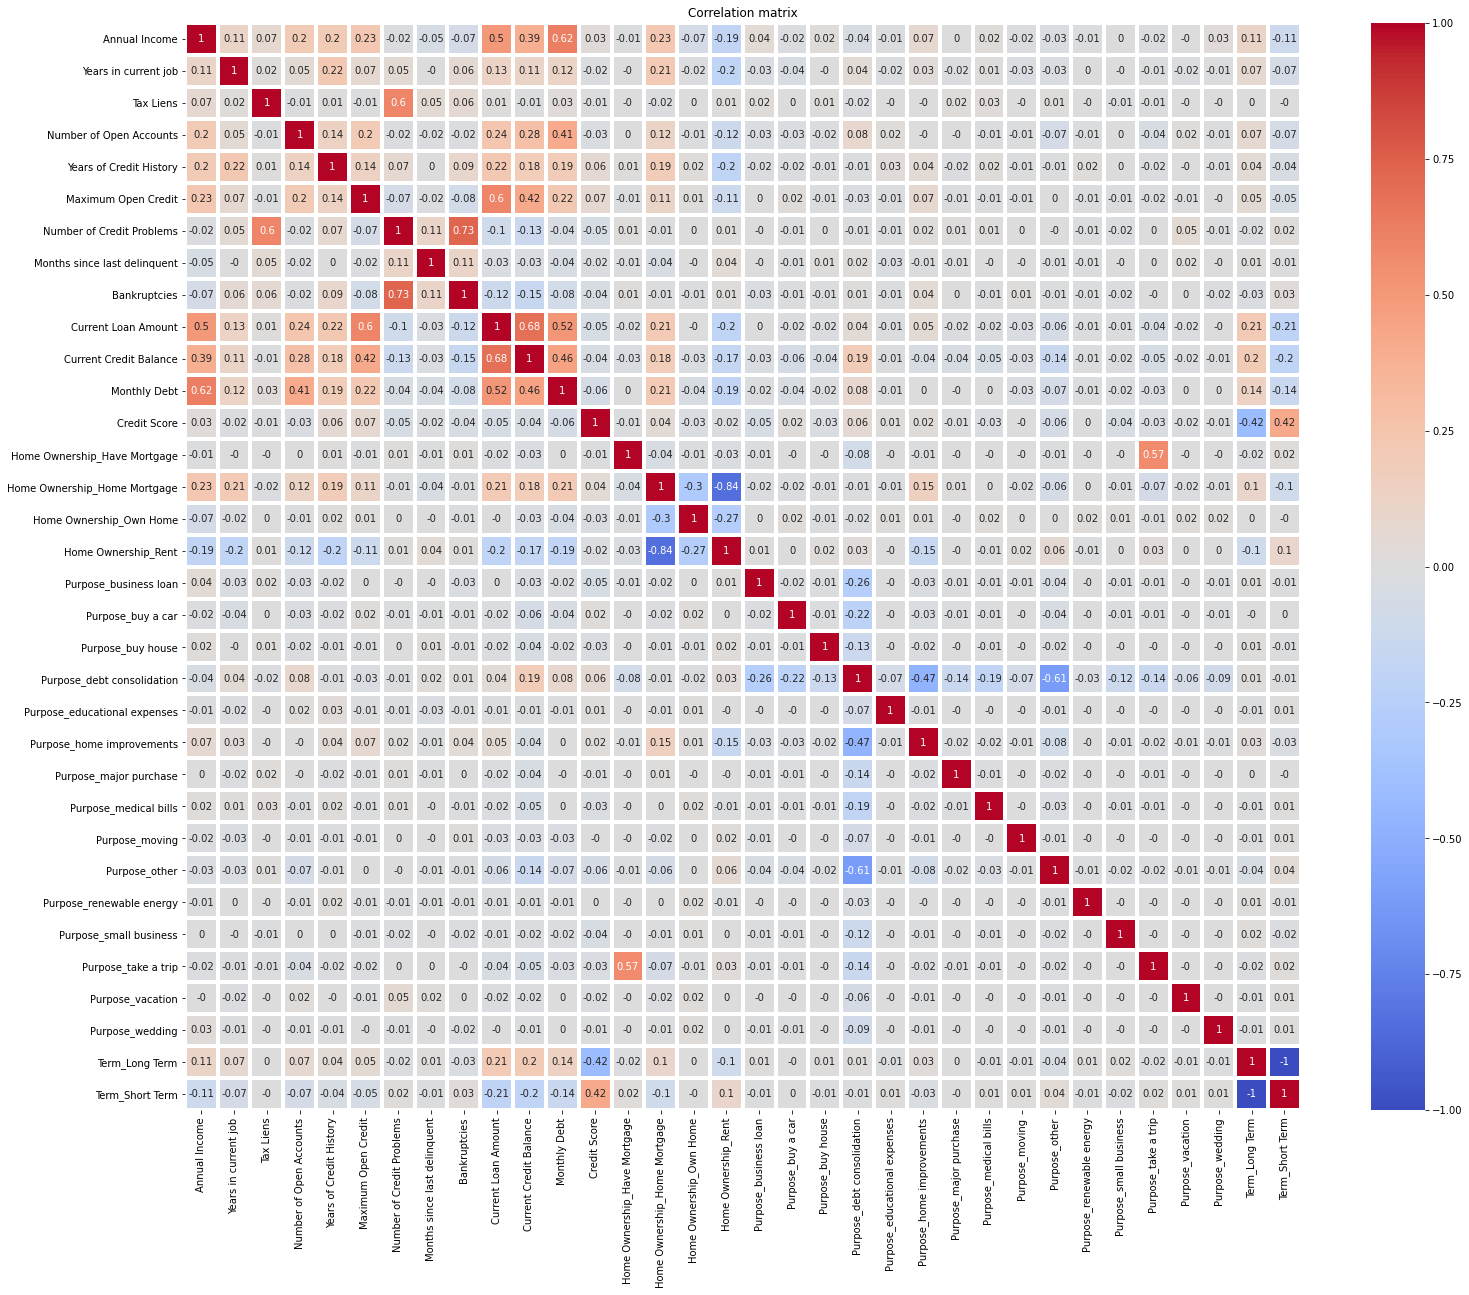

In [393]:
# отмечаем хорошую корреляцию 
# 'Current Loan Amount' и 'Current Credit Balance'
# 'Number of Credit Problems' и 'Bankruptcies'
# возможно их лучше будет объединить попарно в 1 признак

plt.figure(figsize = (25,20))

sns.heatmap(train_data_corr.round(2), annot = True, cmap = 'coolwarm', linewidth = 3)
plt.title('Correlation matrix')

Text(0.5, 1.0, 'Correlation matrix')

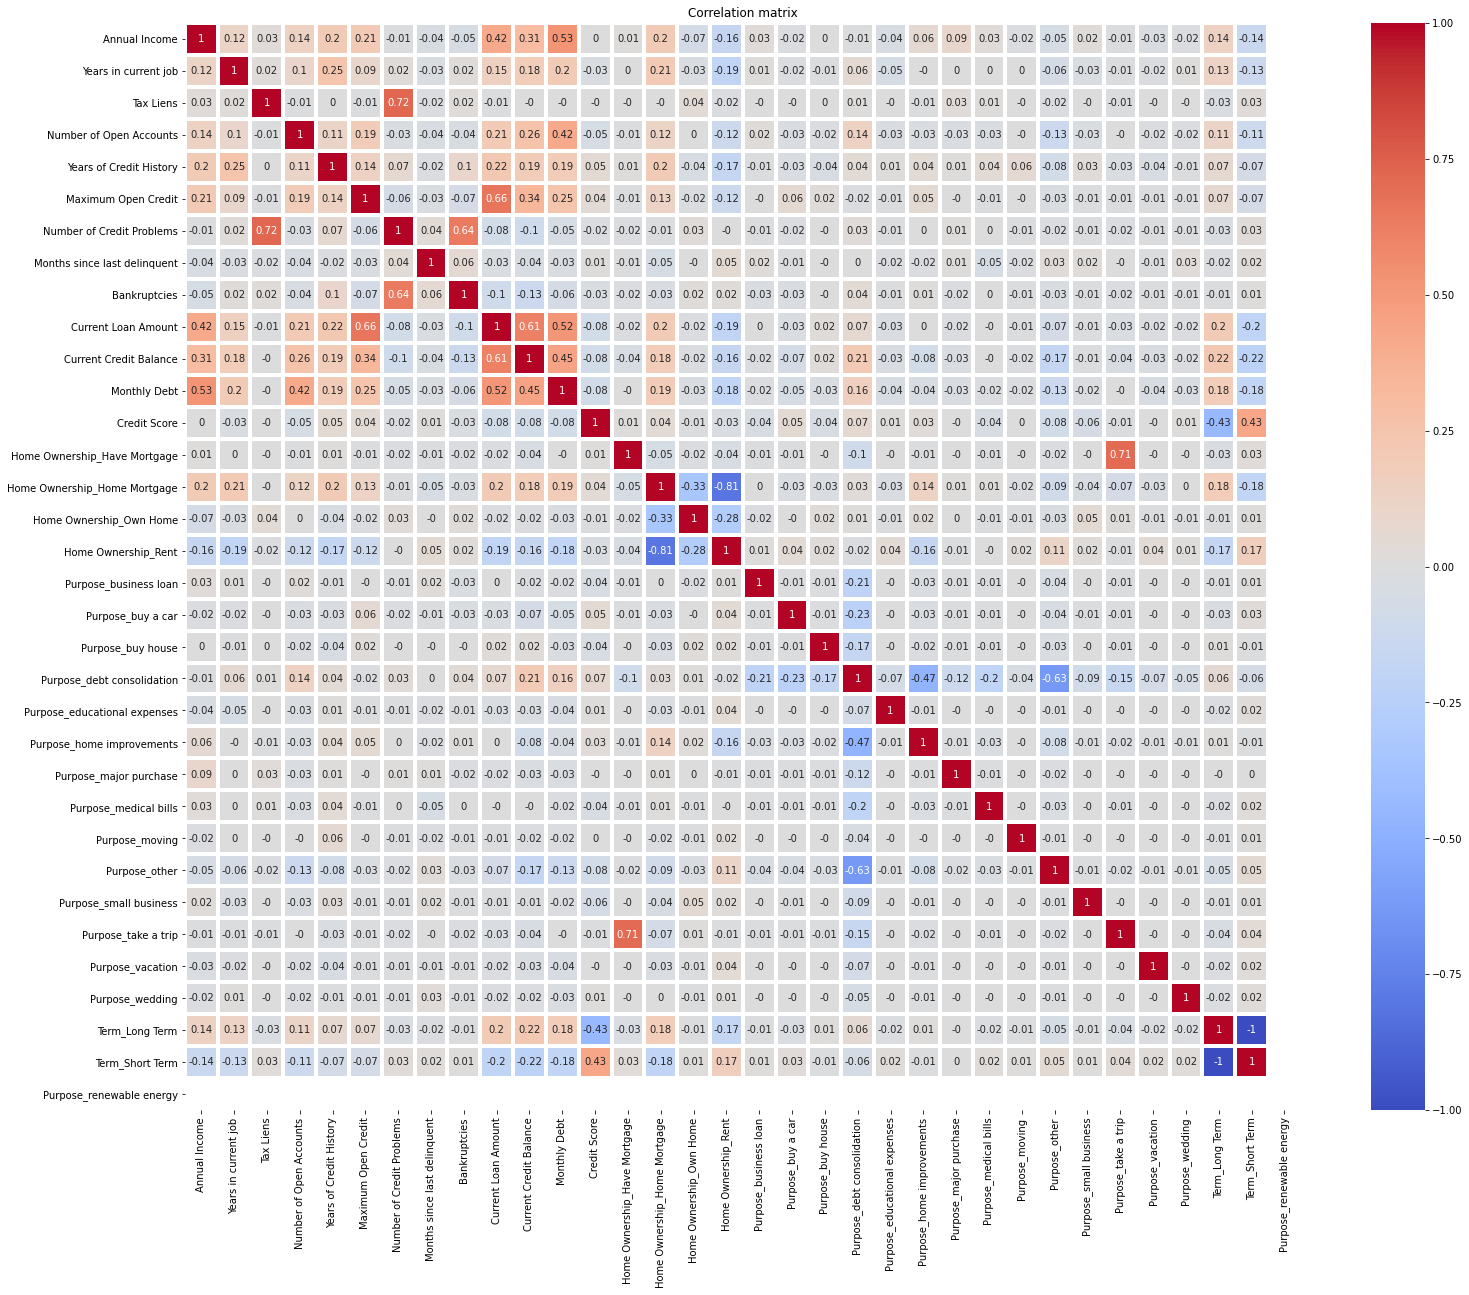

In [394]:
plt.figure(figsize = (25,20))

sns.heatmap(test_data_corr.round(2), annot = True, cmap = 'coolwarm', linewidth = 3)
plt.title('Correlation matrix')


Text(0.5, 1.0, 'Correlation matrix')

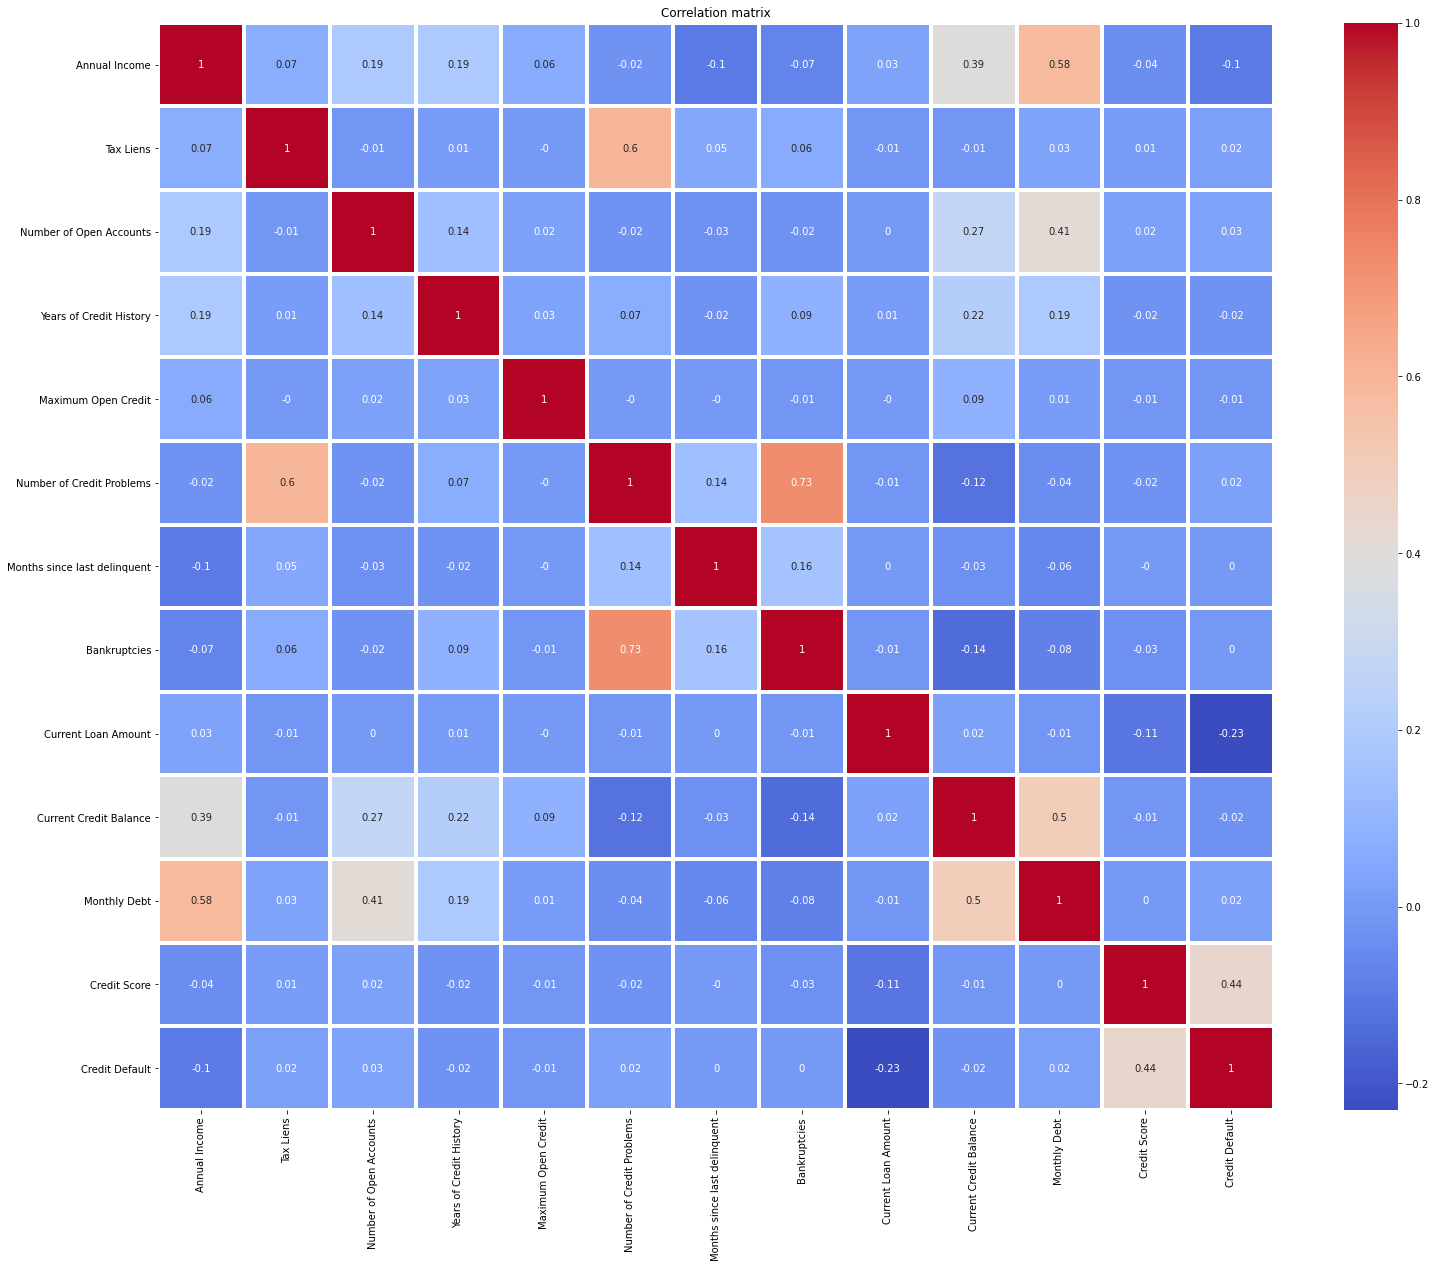

In [395]:
# наибольшая линейная корреляция целевой переменной наблюдается с Credit Score

plt.figure(figsize = (25,20))

sns.heatmap(train_corr.round(2), annot = True, cmap = 'coolwarm', linewidth = 3)
plt.title('Correlation matrix')

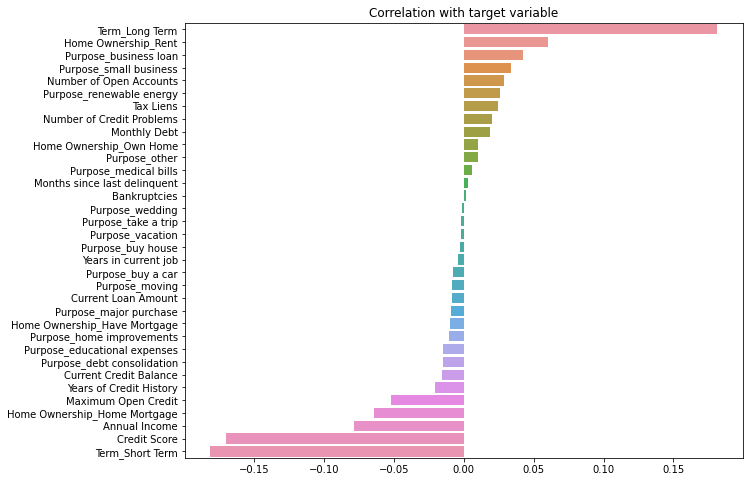

In [396]:
TARGET_NAME = 'Credit Default'
train_data_t = train_data.copy()
train_data_t[TARGET_NAME] = train[TARGET_NAME] 
train_data_t

corr_with_target = train_data_t.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
#sns.barplot(x=train.values, y=train.index)

plt.title('Correlation with target variable')
plt.show()

In [397]:
# масштабирование данных
# по графику построенному ниже видно, что изначальные данные 'не нормальные'
# после визуальной оценки проводим тесты, подтверждающие отсутствие нормального распределения данных
# проводим масштабирование данных

In [398]:
scaler_1 = StandardScaler()
train_data_scaled_st = pd.DataFrame(scaler_1.fit_transform(train_data), columns=train_data.columns)
test_data_scaled_st = pd.DataFrame(scaler_1.transform(test_data), columns=test_data.columns)
train_data_scaled_st.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,-1.112443,0.032226,-0.110953,-0.026674,1.133645,0.000287,1.664779,-0.083484,2.545732,-0.475700,-0.909626,-0.872085,1.076232,-0.040032,-0.970307,3.254530,-0.863603,-0.132291,-0.113868,-0.067483,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
1,-0.428896,1.165605,-0.110953,0.788223,-0.428528,0.392674,-0.340979,-0.083484,-0.337099,0.006835,0.216931,0.004909,0.599014,-0.040032,-0.970307,3.254530,-0.863603,-0.132291,-0.113868,-0.067483,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,1.690569,-1.690569
2,-0.773657,0.598916,-0.110953,-0.026674,2.369181,0.393231,-0.340979,-0.083484,-0.337099,0.363095,0.441748,-0.391034,0.797855,-0.040032,1.030601,-0.307264,-0.863603,-0.132291,-0.113868,-0.067483,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
3,-0.706163,0.032226,-0.110953,-0.637847,0.593985,-0.425967,1.664779,-0.083484,2.545732,-0.849949,-0.658672,-0.584980,-1.111016,-0.040032,-0.970307,3.254530,-0.863603,-0.132291,-0.113868,-0.067483,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517
4,-0.742395,0.598916,-0.110953,0.380774,-0.669954,-0.237252,1.664779,-0.083484,-0.337099,-0.836031,-0.671854,-0.933631,-0.116812,-0.040032,-0.970307,-0.307264,1.157940,-0.132291,-0.113868,-0.067483,0.511641,-0.036539,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766,-0.591517,0.591517


In [399]:
scaler_2 = MinMaxScaler()
train_data_scaled_mm = pd.DataFrame(scaler_2.fit_transform(train_data), columns=train_data.columns)
test_data_scaled_mm = pd.DataFrame(scaler_2.transform(test_data), columns=test_data.columns)
train_data_scaled_mm.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,0.031798,0.6,0.0,0.219512,0.415270,0.011917,0.142857,0.271186,0.25,0.035356,0.011151,0.057902,0.987952,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.086221,1.0,0.0,0.317073,0.210428,0.020529,0.000000,0.271186,0.00,0.059076,0.062350,0.134424,0.915663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.058771,0.8,0.0,0.219512,0.577281,0.020542,0.000000,0.271186,0.00,0.076589,0.072568,0.099876,0.945783,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.064145,0.6,0.0,0.146341,0.344507,0.002561,0.142857,0.271186,0.25,0.016958,0.022556,0.082953,0.656627,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.061260,0.8,0.0,0.268293,0.178771,0.006703,0.142857,0.271186,0.00,0.017643,0.021957,0.052532,0.807229,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [400]:
scaler_3 = Normalizer()
train_data_scaled_n = pd.DataFrame(scaler_3.fit_transform(train_data), columns=train_data.columns)
test_data_scaled_n = pd.DataFrame(scaler_3.transform(test_data), columns=test_data.columns)
train_data_scaled_n.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,0.551799,0.000007,0.0,0.000013,0.000030,0.785153,0.000001,0.000037,0.000001,0.275730,0.054238,0.009058,0.000857,0.0,0.000000e+00,1.144605e-06,0.000000,0.0,0.0,0.0,1.144605e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.144605e-06
1,0.627041,0.000006,0.0,0.000009,0.000009,0.722577,0.000000,0.000020,0.000000,0.241508,0.162017,0.011234,0.000451,0.0,0.000000e+00,6.114569e-07,0.000000,0.0,0.0,0.0,6.114569e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.114569e-07,0.000000e+00
2,0.493660,0.000005,0.0,0.000007,0.000023,0.776831,0.000000,0.000021,0.000000,0.334222,0.202604,0.008968,0.000487,0.0,6.569762e-07,0.000000e+00,0.000000,0.0,0.0,0.0,6.569762e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,6.569762e-07
3,0.966450,0.000007,0.0,0.000010,0.000027,0.176947,0.000001,0.000038,0.000001,0.145731,0.115070,0.013611,0.000833,0.0,0.000000e+00,1.200457e-06,0.000000,0.0,0.0,0.0,1.200457e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.200457e-06
4,0.881180,0.000009,0.0,0.000015,0.000015,0.437984,0.000001,0.000036,0.000000,0.142848,0.105920,0.008150,0.000816,0.0,0.000000e+00,0.000000e+00,0.000001,0.0,0.0,0.0,1.135155e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.135155e-06


Text(0, 0.5, 'кредитный рейтинг')

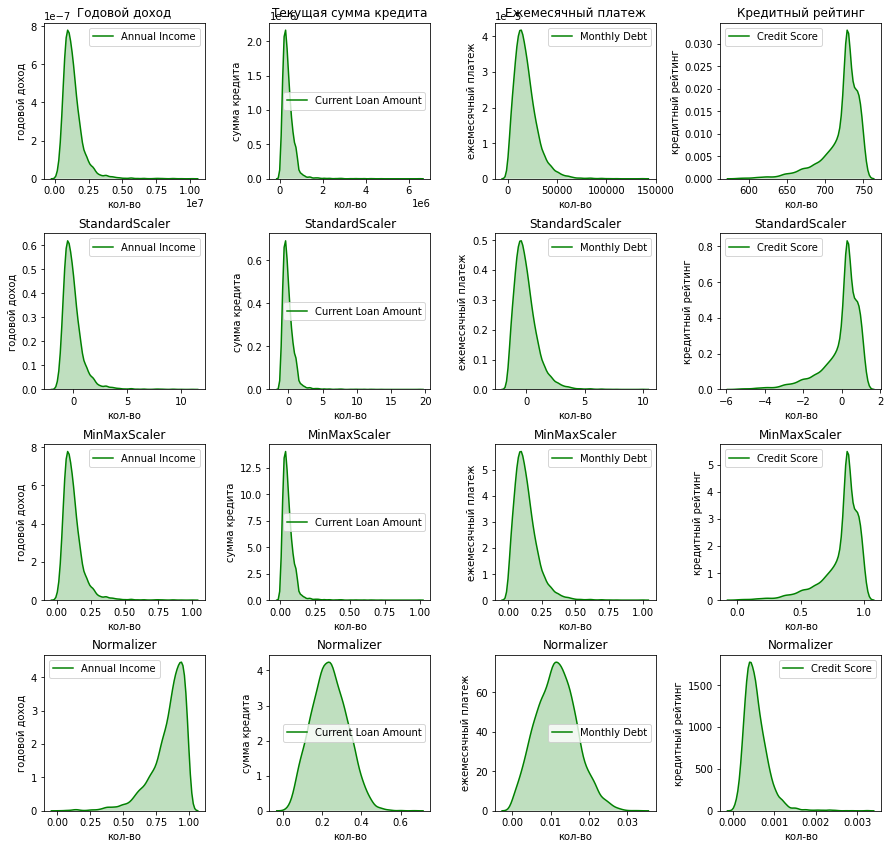

In [401]:
# графики распределения плотности
plt.figure(figsize = ([15,30]))

plt.subplots_adjust(wspace=0.4, hspace=0.35)

plt.subplot(8,4,1)
sns.kdeplot(train_data['Annual Income'], shade=True, color="g")
plt.title('Годовой доход')
plt.xlabel('кол-во')
plt.ylabel('годовой доход')

plt.subplot(8,4,5)
sns.kdeplot(train_data_scaled_st['Annual Income'], shade=True, color="g")
plt.title('StandardScaler')
plt.xlabel('кол-во')
plt.ylabel('годовой доход')

plt.subplot(8,4,9)
sns.kdeplot(train_data_scaled_mm['Annual Income'], shade=True, color="g")
plt.title('MinMaxScaler')
plt.xlabel('кол-во')
plt.ylabel('годовой доход')

plt.subplot(8,4,13)
sns.kdeplot(train_data_scaled_n['Annual Income'], shade=True, color="g")
plt.title('Normalizer')
plt.xlabel('кол-во')
plt.ylabel('годовой доход')


plt.subplot(8,4,2)
sns.kdeplot(train_data['Current Loan Amount'], shade=True, color="g")
plt.title('Текущая сумма кредита')
plt.xlabel('кол-во')
plt.ylabel('сумма кредита')

plt.subplot(8,4,6)
sns.kdeplot(train_data_scaled_st['Current Loan Amount'], shade=True, color="g")
plt.title('StandardScaler')
plt.xlabel('кол-во')
plt.ylabel('сумма кредита')

plt.subplot(8,4,10)
sns.kdeplot(train_data_scaled_mm['Current Loan Amount'], shade=True, color="g")
plt.title('MinMaxScaler')
plt.xlabel('кол-во')
plt.ylabel('сумма кредита')

plt.subplot(8,4,14)
sns.kdeplot(train_data_scaled_n['Current Loan Amount'], shade=True, color="g")
plt.title('Normalizer')
plt.xlabel('кол-во')
plt.ylabel('сумма кредита')


plt.subplot(8,4,3)
sns.kdeplot(train_data['Monthly Debt'], shade=True, color="g")
plt.title('Ежемесячный платеж')
plt.xlabel('кол-во')
plt.ylabel('ежемесячный платеж')

plt.subplot(8,4,7)
sns.kdeplot(train_data_scaled_st['Monthly Debt'], shade=True, color="g")
plt.title('StandardScaler')
plt.xlabel('кол-во')
plt.ylabel('ежемесячный платеж')

plt.subplot(8,4,11)
sns.kdeplot(train_data_scaled_mm['Monthly Debt'], shade=True, color="g")
plt.title('MinMaxScaler')
plt.xlabel('кол-во')
plt.ylabel('ежемесячный платеж')

plt.subplot(8,4,15)
sns.kdeplot(train_data_scaled_n['Monthly Debt'], shade=True, color="g")
plt.title('Normalizer')
plt.xlabel('кол-во')
plt.ylabel('ежемесячный платеж')


plt.subplot(8,4,4)
sns.kdeplot(train_data['Credit Score'], shade=True, color="g")
plt.title('Кредитный рейтинг')
plt.xlabel('кол-во')
plt.ylabel('кредитный рейтинг')

plt.subplot(8,4,8)
sns.kdeplot(train_data_scaled_st['Credit Score'], shade=True, color="g")
plt.title('StandardScaler')
plt.xlabel('кол-во')
plt.ylabel('кредитный рейтинг')

plt.subplot(8,4,12)
sns.kdeplot(train_data_scaled_mm['Credit Score'], shade=True, color="g")
plt.title('MinMaxScaler')
plt.xlabel('кол-во')
plt.ylabel('кредитный рейтинг')

plt.subplot(8,4,16)
sns.kdeplot(train_data_scaled_n['Credit Score'], shade=True, color="g")
plt.title('Normalizer')
plt.xlabel('кол-во')
plt.ylabel('кредитный рейтинг')

In [402]:
train_data.head(2)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,482087.0,6.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,240895.726264,47386.0,7914.0,749.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,394972.000000,264968.0,18373.0,737.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [403]:
# тесты на SciPy

# значение p:

# p <= alpha : отклонить H0, не нормально.
# p> alpha : не отклонить H0, нормально.
# alpha = 0.5

In [404]:
# тесты подтверждают, что данные не имеют нормальное распределение

# Шапиро-Уилк
c,p = shapiro(train_data['Annual Income'])
print(c, p)
c,p = shapiro(train_data['Current Loan Amount'])
print(c, p)
c,p = shapiro(train_data['Credit Score'])
print(c, p)

print()
#D’Agostino’s K2 test
c,p = normaltest(train_data['Annual Income'])
print(p)
c,p = normaltest(train_data['Current Loan Amount'])
print(p)
c,p = normaltest(train_data['Credit Score'])
print(p)

print()
# Колмогоров-Смирнов
c,p = kstest(train_data['Annual Income'], 'norm')
print(p)
c,p = kstest(train_data['Current Loan Amount'], 'norm')
print(p)
c,p = kstest(train_data['Credit Score'], 'norm')
print(p)

0.7783339023590088 0.0
0.6692125797271729 0.0
0.8110946416854858 0.0

0.0
0.0
0.0

0.0
0.0
0.0


In [405]:
# тесты подтверждают, что данные после проведения масштабирования так же не имеют нормального распределения

# Шапиро-Уилк
c,p = shapiro(train_data_scaled_n['Current Loan Amount'])
print(c, p)

#D’Agostino’s K2 test
c,p = normaltest(train_data_scaled_n['Current Loan Amount'])
print(p)

# Колмогоров-Смирнов
c,p = kstest(train_data_scaled_n['Current Loan Amount'], 'norm')
print(p)

0.9946562647819519 4.153880013581631e-16
2.0652361512637884e-17
0.0


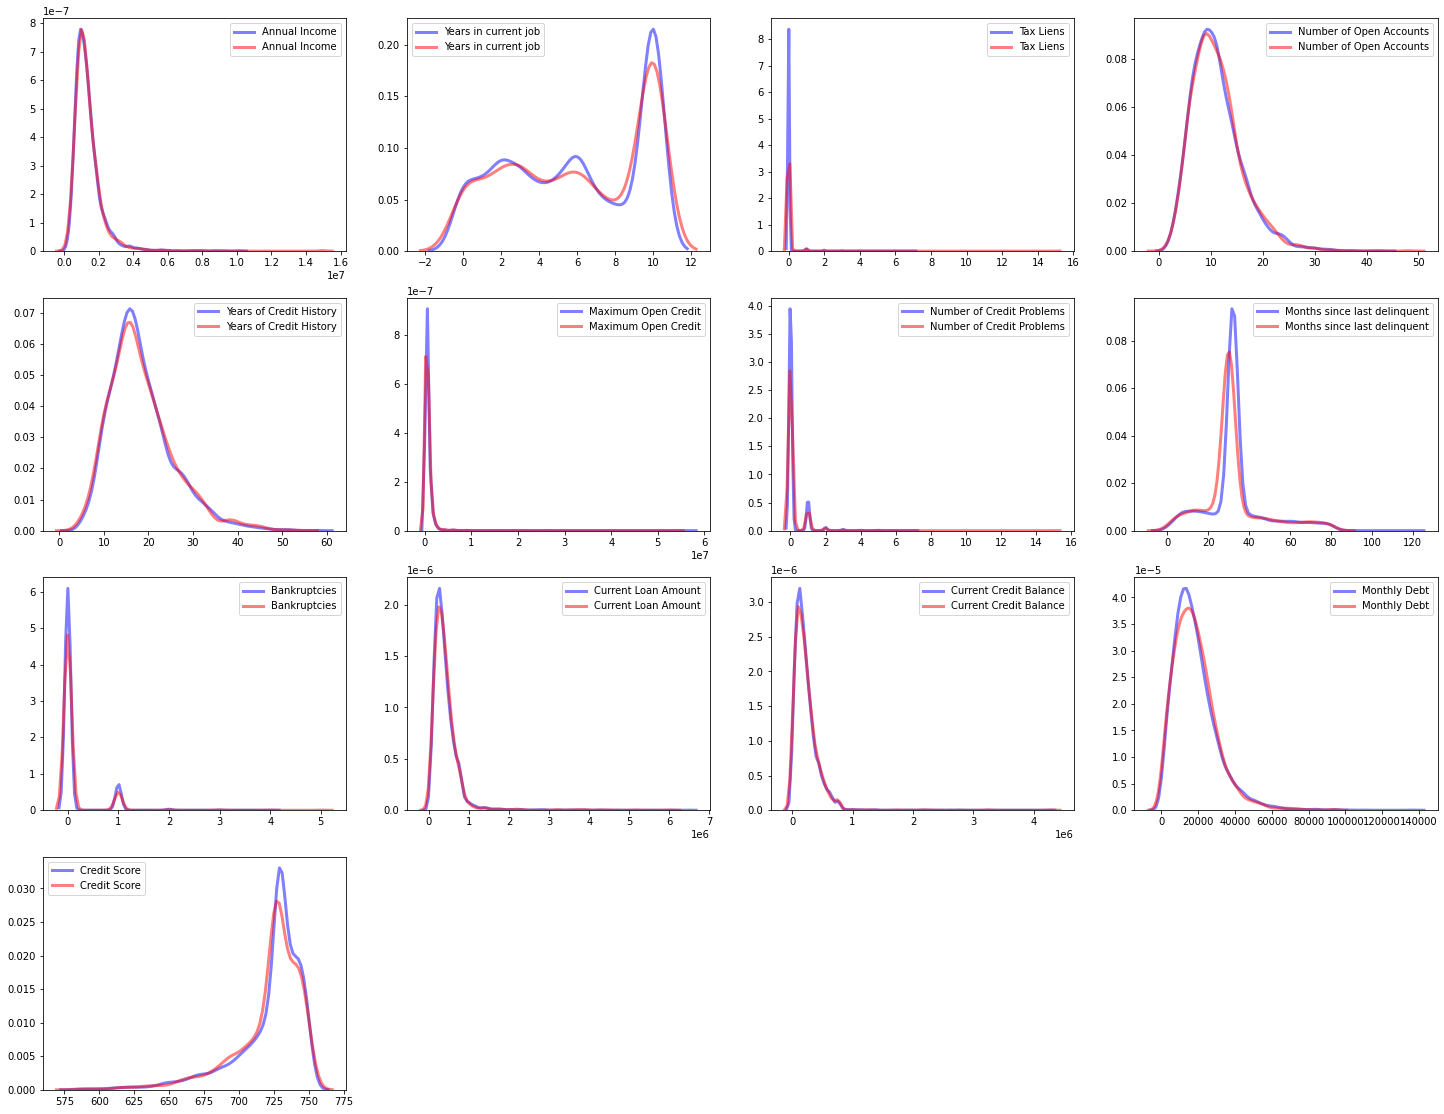

In [406]:
# рассмотрим насколько аналогичны распределения в тренировочной и тестовой выборке
# вывод: данные близки по распределениюю имеют схожие параметры

name_col = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']

plt.figure(figsize = ([25,30]))


for n, m in enumerate(name_col, 1):
    plt.subplot(6,4,n)
    sns.kdeplot(train_data[m],alpha=0.5,label= m, color='blue', linewidth = 3)
    sns.kdeplot(test_data[m],alpha=0.5,label= m, color='r', linewidth = 3)

In [407]:
# несмотря на визуальное сходство, Annual Income и Credit Score по двух выборочному тесту имеют разные параметры,
# т.е. разные законы распределения

for n, m in enumerate(name_col, 1):
    print(m)
    print(ks_2samp(train_data[m], test_data[m]))

Annual Income
KstestResult(statistic=0.016266666666666665, pvalue=0.7008088991276012)
Years in current job
KstestResult(statistic=0.018933333333333333, pvalue=0.509230262822794)
Tax Liens
KstestResult(statistic=0.0041333333333333335, pvalue=0.9999999999999994)
Number of Open Accounts
KstestResult(statistic=0.0168, pvalue=0.6619915189806798)
Years of Credit History
KstestResult(statistic=0.0168, pvalue=0.6619915189806798)
Maximum Open Credit
KstestResult(statistic=0.011733333333333333, pvalue=0.9572345173268135)
Number of Credit Problems
KstestResult(statistic=0.008266666666666667, pvalue=0.9994939493915016)
Months since last delinquent
KstestResult(statistic=0.5590666666666667, pvalue=0.9999995698667535)
Bankruptcies
KstestResult(statistic=0.012133333333333333, pvalue=0.9437979931682795)
Current Loan Amount
KstestResult(statistic=0.022133333333333335, pvalue=0.31500223547934403)
Current Credit Balance
KstestResult(statistic=0.0232, pvalue=0.2631027551614704)
Monthly Debt
KstestResult(s

In [408]:
train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [409]:
train_data_full.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term', 'Credit Default', 'Id'],
      dtype='object')

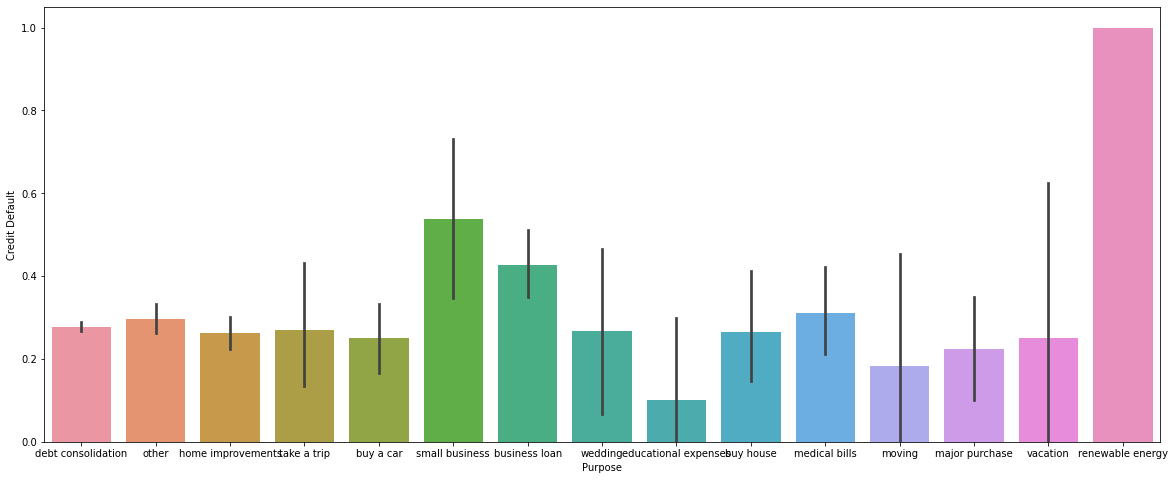

In [410]:
# анализируем категориальную переменную цель кредита - она имеет очень большое кол-во дамми переменных
plt.figure(figsize = ([20,8]))
sns.barplot(train_data_full['Purpose'], y = train_target)

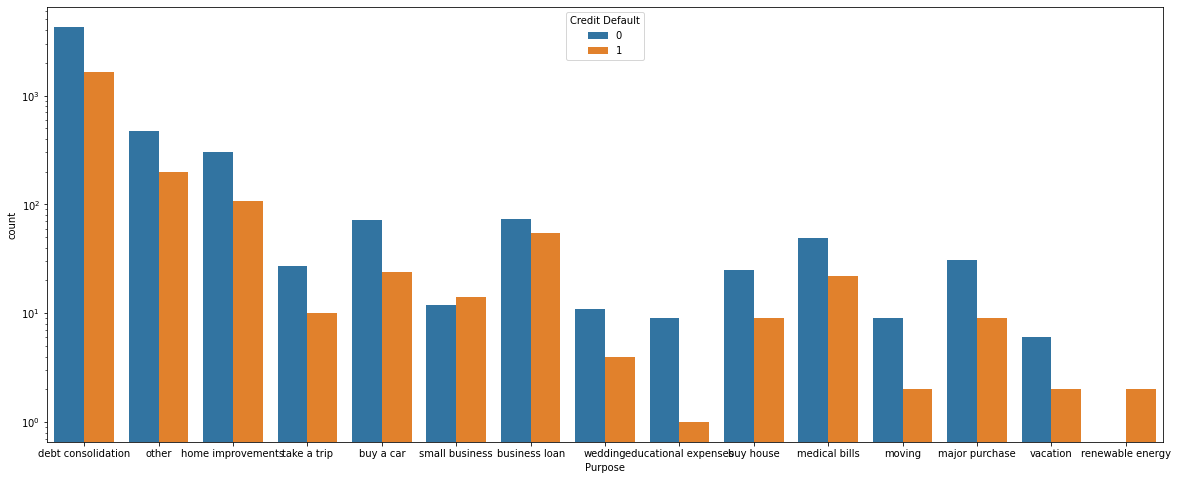

In [411]:
plt.figure(figsize = ([20,8]))
sns.countplot(x="Purpose", hue=train_target, data=train_data_full,log=True)

In [412]:
name_purpose = train_data_full['Purpose'].value_counts()
name_purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [413]:
# проверяем какие категории одинаково влияют на целевую переменную методом Хи-квадрат Пирсона
# P-value ниже выбранного уровня значимости: business loan, small business, слодовательно остальные дамми 
# можно попробовать потом объединить методом главных компонент

for i in name_purpose.index:
    if i == 'debt consolidation':
        continue
    purpose_i = train_data_full.loc[train_data_full['Purpose'].isin(['debt consolidation', i]), ['Id', 'Purpose', 'Credit Default']]
    table = purpose_i.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    print(i, p)

other 0.3275437662812281
home improvements 0.47942565481893473
business loan 0.00021520390170564772
buy a car 0.5396666095625493
medical bills 0.5549849142456016
major purchase 0.4535689964677201
take a trip 0.9138626210237686
buy house 0.8603574551362954
small business 0.00317344339657794
wedding 0.9202628969160936
moving 0.47568757879926316
educational expenses 0.20866040001354255
vacation 0.8585090782479671
renewable energy nan


In [414]:
# business loan и small business так же можно попробовать объединить в 1 

for i in name_purpose.index:
    if i == 'business loan':
        continue
    purpose_i = train_data_full.loc[train_data_full['Purpose'].isin(['business loan', i]), ['Id', 'Purpose', 'Credit Default']]
    table = purpose_i.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    print(i, p)

debt consolidation 0.00021520390170564772
other 0.0036646467408851567
home improvements 0.000388811687909952
buy a car 0.006123555211802671
medical bills 0.10519826093772455
major purchase 0.021803851851024757
take a trip 0.08639366280214192
buy house 0.08595905952637853
small business 0.29404148780405304
wedding 0.23392059834276552
moving 0.11305212746174147
educational expenses 0.04265867419909915
vacation 0.32610217214232506
renewable energy nan


In [415]:
test_data.head(2)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Purpose_renewable energy
0,760213.855095,4.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,6813.0,727.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.0
1,231838.000000,1.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,2318.0,699.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0


In [416]:
##################################################################################################################

In [417]:
train_data.head(2)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,482087.0,6.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,240895.726264,47386.0,7914.0,749.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,394972.000000,264968.0,18373.0,737.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [418]:
#train_data.columns

In [419]:
# числовые признаки
num_feature_names = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# категориальные признаки
cat_feature_names = ['Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent', 
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Purpose_major purchase',
       'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding', 
       'Term_Long Term', 'Term_Short Term', ]

# переводим категориальные признаки в int
train_data[cat_feature_names] = train_data[cat_feature_names].astype(int)

# стандартизируем числовые признаки
scaler_1 = StandardScaler()

train_data_st  = train_data.copy()
train_data_st[num_feature_names] = pd.DataFrame(scaler_1.fit_transform(train_data[num_feature_names]), columns=train_data[num_feature_names].columns)

test_data_st  = test_data.copy()
test_data_st[num_feature_names] = pd.DataFrame(scaler_1.transform(test_data[num_feature_names]), columns=test_data[num_feature_names].columns)

train_data_st.head(2)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,-1.112443,0.032226,-0.110953,-0.026674,1.133645,0.000287,1.664779,-0.083484,2.545732,-0.475700,-0.909626,-0.872085,1.076232,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.428896,1.165605,-0.110953,0.788223,-0.428528,0.392674,-0.340979,-0.083484,-0.337099,0.006835,0.216931,0.004909,0.599014,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [420]:
# оцениваем целевую переменную - данные разбалансированы
train_target.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [421]:
disbalance_coeff = int(train_target.value_counts()[0] / train_target.value_counts()[1])
disbalance_coeff

2

In [422]:
# балансировка данных oversampling
train_st_balansing = pd.concat([train_data_st, train_target], axis=1)
train_st_target_1 = train_st_balansing.loc[(train_st_balansing['Credit Default'] == 1)]
train_st_balansing_plus = pd.concat([train_st_balansing, train_st_target_1], axis=0)
train_st_balansing_plus_target = train_st_balansing_plus['Credit Default']
train_st_balansing_plus_data = train_st_balansing_plus.drop(['Credit Default'], axis = 'columns')
train_st_balansing_plus_target
train_st_balansing_plus_data.head(2)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,-1.112443,0.032226,-0.110953,-0.026674,1.133645,0.000287,1.664779,-0.083484,2.545732,-0.475700,-0.909626,-0.872085,1.076232,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.428896,1.165605,-0.110953,0.788223,-0.428528,0.392674,-0.340979,-0.083484,-0.337099,0.006835,0.216931,0.004909,0.599014,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [423]:
# балансировка данных undersampling
train_st_target_0 = train_st_balansing.loc[(train_st_balansing['Credit Default'] == 0)].sample(2113)
train_st_balansing_minus = pd.concat([train_st_target_1, train_st_target_0], axis=0)
train_st_balansing_minus_target = train_st_balansing_minus['Credit Default']
train_st_balansing_minus_data = train_st_balansing_minus.drop(['Credit Default'], axis = 'columns')
train_st_balansing_minus. head(2)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Credit Default
1,-0.428896,1.165605,-0.110953,0.788223,-0.428528,0.392674,-0.340979,-0.083484,-0.337099,0.006835,0.216931,0.004909,0.599014,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5,-0.128331,0.315571,-0.110953,0.177050,-0.527939,-0.252331,-0.340979,-0.083484,-0.337099,-0.173769,-0.297145,0.031657,0.280869,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1


In [424]:
# создаем модели
logreg = LogisticRegression()
knn = KNeighborsClassifier()
clf = SGDClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()        #(n_estimators=500, max_depth = 7)
gbc = GradientBoostingClassifier()
hgbc = HistGradientBoostingClassifier()
abc = AdaBoostClassifier()

xgb_mod = xgb.XGBClassifier()
lgbm_mod = lgbm.LGBMClassifier()
catb_mod = catb.CatBoostClassifier(silent=True) #(silent=True, n_estimators = 700, max_depth = 7, cat_features = cat_feature_names, ignored_features = catb_mod_feature_non)

voiting = VotingClassifier([('rfc', rfc), ('knn', knn), ('xgb_mod', xgb_mod)]) 

In [425]:
# проверка моделей кросс-валидацией
scores = cross_val_score(logreg, train_data_st, train_target, cv=5, scoring='f1')
#y_pred = cross_val_predict(catb_mod, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5)
scores.mean()

0.19256973042794773

In [426]:
# проверка моделей кросс-валидацией
scores = cross_val_score(logreg, train_st_balansing_minus_data, train_st_balansing_minus_target, cv=5, scoring='f1')
#y_pred = cross_val_predict(catb_mod, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5)
scores.mean()

0.5884836979768713

In [427]:
# проверка моделей кросс-валидацией
scores = cross_val_score(logreg, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5, scoring='f1')
#y_pred = cross_val_predict(catb_mod, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5)
scores.mean()

0.4916844963591192

In [428]:
# наилучшие результаты преимущественно при балансировке oversampling

#модели     -   st  - minus - plus  -

#logreg     - 0.187 - 0.586 - 0.492 -
#knn        - 0.252 - 0.555 - 0.609 -
#clf        - 0.208 - 0.593 - 0.497 -
#dtc        - 0.337 - 0.541 - 0.832 -
#rfc        - 0.216 - 0.589 - 0.914 -
#gbc        - 0.197 - 0.614 - 0.562 -
#hgbc       - 0.271 - 0.595 - 0.686 -
#abc        - 0.240 - 0.615 - 0.553 -

#xgb_mod    - 0.304 - 0.593 - 0.789 -
#lgbm_mod   - 0.269 - 0.594 - 0.689 -
#catb_mod   - 0.237 - 0.616 - 0.685 -

#voiting    - 0.235 - 0.592 - 0.854 -

In [429]:
# произведем объединение некоторых компонент методом PCA для упрощения модели


In [430]:
#pca = PCA(n_components=1)
#F_1 = pca.fit_transform(train_st_balansing_plus_data.loc[:,['Bankruptcies', 'Number of Credit Problems']].values)
#train_st_balansing_plus_data['F_1'] = F_1
#train_st_balansing_plus_data = train_st_balansing_plus_data.drop(['Bankruptcies', 'Number of Credit Problems'], axis = 'columns')
#train_st_balansing_plus_data.head(2)


In [431]:
#pca = PCA(n_components=1)
#F_2 = pca.fit_transform(train_st_balansing_plus_data.loc[:,['Current Loan Amount', 'Current Credit Balance']].values)
#train_st_balansing_plus_data['F_2'] = F_2
#train_st_balansing_plus_data = train_st_balansing_plus_data.drop(['Current Loan Amount', 'Current Credit Balance'], axis = 'columns')
#train_st_balansing_plus_data.head(2)


In [432]:
#num_feature_names = ['Annual Income', 'Years in current job', 'Tax Liens',
#       'Number of Open Accounts', 'Years of Credit History',
#       'Maximum Open Credit', 'Months since last delinquent', 'Monthly Debt', 
#       'Credit Score', 'F_1, F_2']

In [433]:
# проверка моделей кросс-валидацией
#scores = cross_val_score(voiting, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5, scoring='f1')
#y_pred = cross_val_predict(catb_mod, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5)
#scores.mean()

In [434]:
# применение PCA F_1, F_2 не дало улучшений, поэтому данная манипуляция с данными отключена

#модели     - plus  -  PCA  - 

#logreg     - 0.492 - 0.487 - 
#knn        - 0.609 - 0.618 - 
#clf        - 0.497 - 0.497 - 
#dtc        - 0.832 - 0.832 - 
#rfc        - 0.914 - 0.911 - 
#gbc        - 0.562 - 0.563 - 
#hgbc       - 0.686 - 0.676 - 
#abc        - 0.553 - 0.548 - 

#xgb_mod    - 0.789 - 0.768 - 
#lgbm_mod   - 0.689 - 0.685 - 
#catb_mod   - 0.685 - 0.679 - 

#voiting    - 0.854 - 0.843 - 

In [435]:
# оцениванием значимость признаков на моделях:
#rfc, gbc, abc, lgbm_mod, catb_mod

In [436]:
# делим выборки на train и test
x_train, x_test, y_train, y_test = train_test_split(train_st_balansing_plus_data, train_st_balansing_plus_target, test_size=0.30)

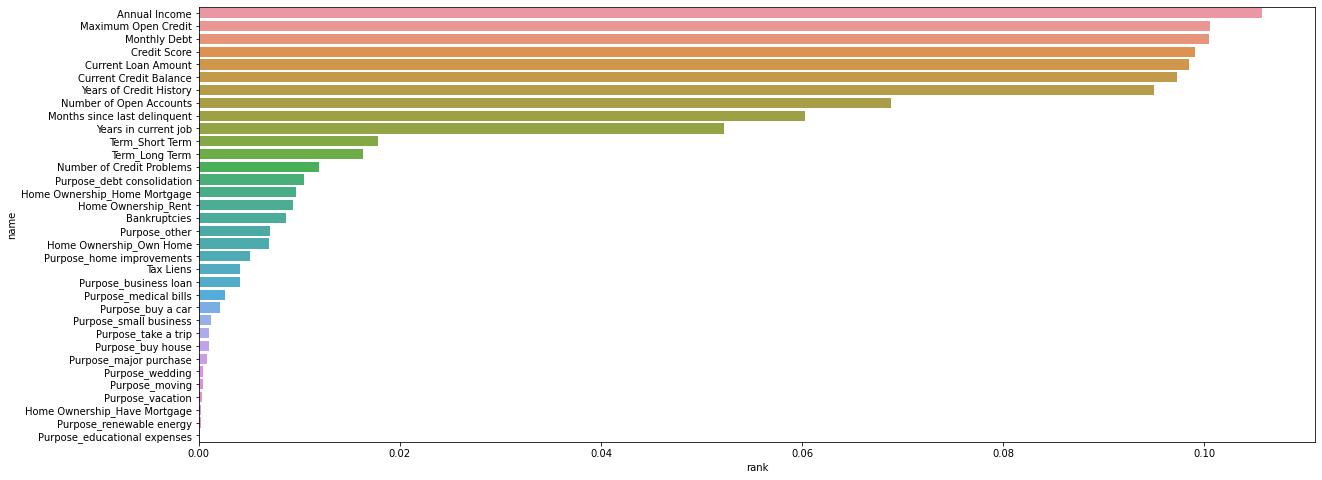

In [437]:
# обучаем модель
rfc.fit(x_train, y_train)  
# записываем в переменную feature_importances_
rank_feature_importances_ = rfc.feature_importances_
# создаем dataframe feature_importances_
train_feature_importances = pd.DataFrame(rank_feature_importances_, train_st_balansing_plus_data.columns)
train_feature_importances.reset_index(inplace=True)
train_feature_importances = train_feature_importances.rename(columns={'index': 'name', 0: 'rank'}) 
train_feature_importances.sort_values(by="rank", inplace=True, ascending = False)
# обображаем feature_importances_ на графике
plt.figure(figsize = ([20,8]))
sns.barplot(train_feature_importances['rank'], train_feature_importances['name'])

In [438]:
# список признаков в порядке убывания значимости
train_feature_importances['name']

0                    Annual Income
5              Maximum Open Credit
11                    Monthly Debt
12                    Credit Score
9              Current Loan Amount
10          Current Credit Balance
4          Years of Credit History
3          Number of Open Accounts
7     Months since last delinquent
1             Years in current job
33                 Term_Short Term
32                  Term_Long Term
6        Number of Credit Problems
20      Purpose_debt consolidation
14    Home Ownership_Home Mortgage
16             Home Ownership_Rent
8                     Bankruptcies
26                   Purpose_other
15         Home Ownership_Own Home
22       Purpose_home improvements
2                        Tax Liens
17           Purpose_business loan
24           Purpose_medical bills
18               Purpose_buy a car
28          Purpose_small business
29             Purpose_take a trip
19               Purpose_buy house
23          Purpose_major purchase
31                 P

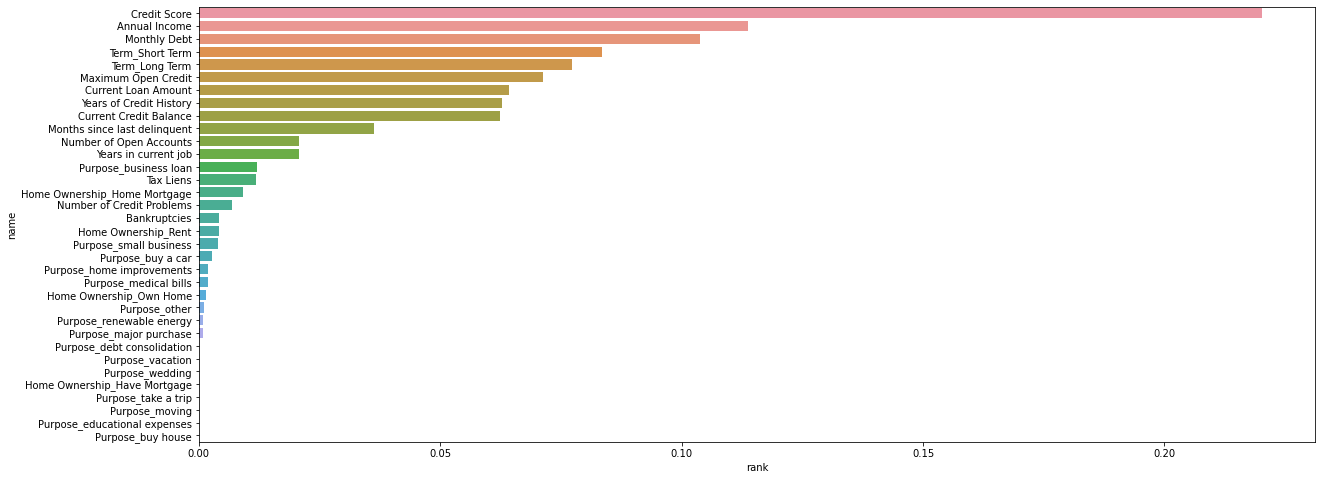

In [439]:
gbc.fit(x_train, y_train)  

rank_feature_importances_ = gbc.feature_importances_

train_feature_importances = pd.DataFrame(rank_feature_importances_, train_st_balansing_plus_data.columns)
train_feature_importances.reset_index(inplace=True)
train_feature_importances = train_feature_importances.rename(columns={'index': 'name', 0: 'rank'}) 
train_feature_importances.sort_values(by="rank", inplace=True, ascending = False)

plt.figure(figsize = ([20,8]))
sns.barplot(train_feature_importances['rank'], train_feature_importances['name'])

In [440]:
train_feature_importances['name']

12                    Credit Score
0                    Annual Income
11                    Monthly Debt
33                 Term_Short Term
32                  Term_Long Term
5              Maximum Open Credit
9              Current Loan Amount
4          Years of Credit History
10          Current Credit Balance
7     Months since last delinquent
3          Number of Open Accounts
1             Years in current job
17           Purpose_business loan
2                        Tax Liens
14    Home Ownership_Home Mortgage
6        Number of Credit Problems
8                     Bankruptcies
16             Home Ownership_Rent
28          Purpose_small business
18               Purpose_buy a car
22       Purpose_home improvements
24           Purpose_medical bills
15         Home Ownership_Own Home
26                   Purpose_other
27        Purpose_renewable energy
23          Purpose_major purchase
20      Purpose_debt consolidation
30                Purpose_vacation
31                 P

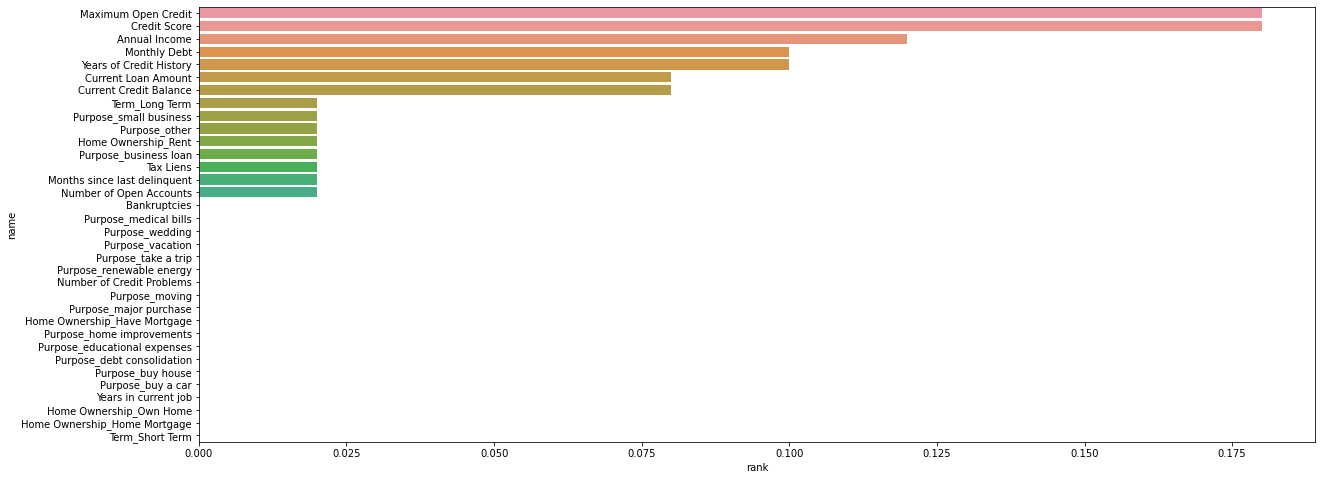

In [441]:
abc.fit(x_train, y_train)  

rank_feature_importances_ = abc.feature_importances_

train_feature_importances = pd.DataFrame(rank_feature_importances_, train_st_balansing_plus_data.columns)
train_feature_importances.reset_index(inplace=True)
train_feature_importances = train_feature_importances.rename(columns={'index': 'name', 0: 'rank'}) 
train_feature_importances.sort_values(by="rank", inplace=True, ascending = False)

plt.figure(figsize = ([20,8]))
sns.barplot(train_feature_importances['rank'], train_feature_importances['name'])

In [442]:
train_feature_importances['name']

5              Maximum Open Credit
12                    Credit Score
0                    Annual Income
11                    Monthly Debt
4          Years of Credit History
9              Current Loan Amount
10          Current Credit Balance
32                  Term_Long Term
28          Purpose_small business
26                   Purpose_other
16             Home Ownership_Rent
17           Purpose_business loan
2                        Tax Liens
7     Months since last delinquent
3          Number of Open Accounts
8                     Bankruptcies
24           Purpose_medical bills
31                 Purpose_wedding
30                Purpose_vacation
29             Purpose_take a trip
27        Purpose_renewable energy
6        Number of Credit Problems
25                  Purpose_moving
23          Purpose_major purchase
13    Home Ownership_Have Mortgage
22       Purpose_home improvements
21    Purpose_educational expenses
20      Purpose_debt consolidation
19               Pur

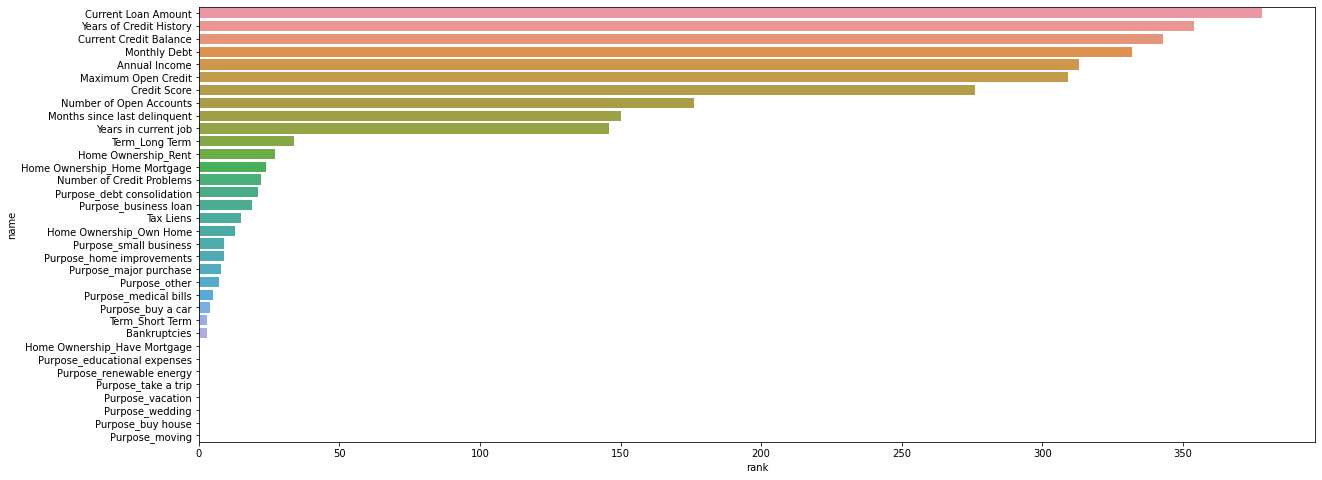

In [443]:
lgbm_mod.fit(x_train, y_train)  

rank_feature_importances_ = lgbm_mod.feature_importances_

train_feature_importances = pd.DataFrame(rank_feature_importances_, train_st_balansing_plus_data.columns)
train_feature_importances.reset_index(inplace=True)
train_feature_importances = train_feature_importances.rename(columns={'index': 'name', 0: 'rank'}) 
train_feature_importances.sort_values(by="rank", inplace=True, ascending = False)

plt.figure(figsize = ([20,8]))
sns.barplot(train_feature_importances['rank'], train_feature_importances['name'])

In [444]:
train_feature_importances['name']

9              Current Loan Amount
4          Years of Credit History
10          Current Credit Balance
11                    Monthly Debt
0                    Annual Income
5              Maximum Open Credit
12                    Credit Score
3          Number of Open Accounts
7     Months since last delinquent
1             Years in current job
32                  Term_Long Term
16             Home Ownership_Rent
14    Home Ownership_Home Mortgage
6        Number of Credit Problems
20      Purpose_debt consolidation
17           Purpose_business loan
2                        Tax Liens
15         Home Ownership_Own Home
28          Purpose_small business
22       Purpose_home improvements
23          Purpose_major purchase
26                   Purpose_other
24           Purpose_medical bills
18               Purpose_buy a car
33                 Term_Short Term
8                     Bankruptcies
13    Home Ownership_Have Mortgage
21    Purpose_educational expenses
27        Purpose_re

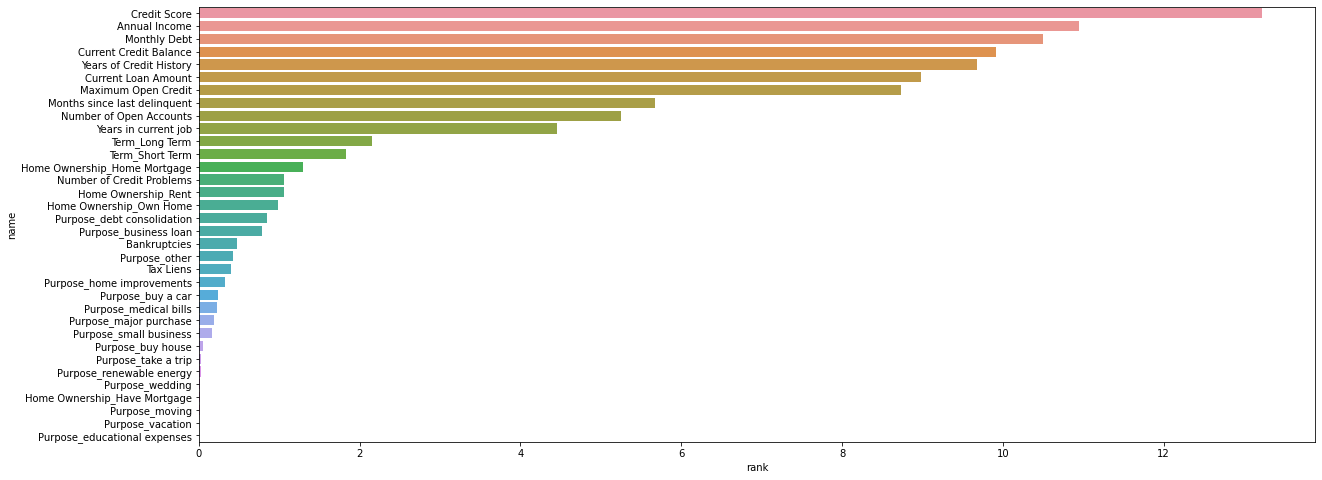

In [445]:
catb_mod.fit(x_train, y_train)  

rank_feature_importances_ = catb_mod.feature_importances_

train_feature_importances = pd.DataFrame(rank_feature_importances_, train_st_balansing_plus_data.columns)
train_feature_importances.reset_index(inplace=True)
train_feature_importances = train_feature_importances.rename(columns={'index': 'name', 0: 'rank'}) 
train_feature_importances.sort_values(by="rank", inplace=True, ascending = False)

plt.figure(figsize = ([20,8]))
sns.barplot(train_feature_importances['rank'], train_feature_importances['name'])

In [446]:
train_feature_importances['name']

12                    Credit Score
0                    Annual Income
11                    Monthly Debt
10          Current Credit Balance
4          Years of Credit History
9              Current Loan Amount
5              Maximum Open Credit
7     Months since last delinquent
3          Number of Open Accounts
1             Years in current job
32                  Term_Long Term
33                 Term_Short Term
14    Home Ownership_Home Mortgage
6        Number of Credit Problems
16             Home Ownership_Rent
15         Home Ownership_Own Home
20      Purpose_debt consolidation
17           Purpose_business loan
8                     Bankruptcies
26                   Purpose_other
2                        Tax Liens
22       Purpose_home improvements
18               Purpose_buy a car
24           Purpose_medical bills
23          Purpose_major purchase
28          Purpose_small business
19               Purpose_buy house
29             Purpose_take a trip
27        Purpose_re

In [447]:
#train_st_balansing_plus_data = train_st_balansing_plus_data.drop(['Bankruptcies', 'Number of Credit Problems', 'Tax Liens'], axis = 'columns')
#train_st_balansing_plus_data = train_st_balansing_plus_data.drop(['Months since last delinquent'], axis = 'columns')
train_st_balansing_plus_data.head(2)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,-1.112443,0.032226,-0.110953,-0.026674,1.133645,0.000287,1.664779,-0.083484,2.545732,-0.475700,-0.909626,-0.872085,1.076232,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.428896,1.165605,-0.110953,0.788223,-0.428528,0.392674,-0.340979,-0.083484,-0.337099,0.006835,0.216931,0.004909,0.599014,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [448]:
# проверка моделей кросс-валидацией
#scores = cross_val_score(knn, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5, scoring='f1')
#y_pred = cross_val_predict(catb_mod, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5)
#scores.mean()

In [449]:
# применение PCA F_1, F_2 не дало улучшений, поэтому данная манипуляция с данными отключена

# f_i_1 - отключение наименее значимых из некатегориальных признаков ['Bankruptcies', 'Number of Credit Problems', 'Tax Liens'], 
# так же не дало улучшения модели

# f_i_2 - отключение признака ['Months since last delinquent'] - с большим кол-вом Null значений замененных медианой, 
# так же не дало улучшения модели


#модели     - plus  -  PCA  -f_i_1  - f_i_2-

#logreg     - 0.492 - 0.487 -       -       -
#knn        - 0.609 - 0.618 -       -       -
#clf        - 0.497 - 0.497 -       -       -
#dtc        - 0.832 - 0.832 -       -       -
#rfc        - 0.914 - 0.911 - 0.914 - 0.911 -
#gbc        - 0.562 - 0.563 -       -       -
#hgbc       - 0.686 - 0.676 -       -       -
#abc        - 0.553 - 0.548 -       -       -

#xgb_mod    - 0.789 - 0.768 - 0.786 - 0.783 -
#lgbm_mod   - 0.689 - 0.685 - 0.686 - 0.687 -
#catb_mod   - 0.685 - 0.679 - 0.684 - 0.682 -

#voiting    - 0.854 - 0.843 - 0.852 - 0.848 - 

In [450]:
catb_mod_feature_non = ['Bankruptcies', 'Tax Liens', 'Home Ownership_Have Mortgage']

In [451]:
# Подбор гиперпараметров
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

kf = KFold(n_splits=5, shuffle=True)

#rs = RandomizedSearchCV(rfc, params, scoring='f1', cv=kf, n_jobs=-1)
#rs.fit(train_st_balansing_plus_data, train_st_balansing_plus_target)
#rs.best_score_, rs.best_params_

# Результат (0.5014206423899443, {'n_estimators': 1200, 'max_depth': 7})

In [452]:
#rs = RandomizedSearchCV(gbc, params, scoring='f1', cv=kf, n_jobs=-1)
#rs.fit(train_st_balansing_plus_data, train_st_balansing_plus_target)
#rs.best_score_, rs.best_params_

# Результат (0.8306253368408111, {'n_estimators': 500, 'max_depth': 7})

In [453]:
#rs = RandomizedSearchCV(xgb_mod, params, scoring='f1', cv=kf, n_jobs=-1)
#rs.fit(train_st_balansing_plus_data, train_st_balansing_plus_target)
#rs.best_score_, rs.best_params_
# Результат (0.8184107926564643, {'n_estimators': 500, 'max_depth': 7})

In [454]:
#rs = RandomizedSearchCV(catb_mod, params, scoring='f1', cv=kf, n_jobs=-1)
#rs.fit(train_st_balansing_plus_data, train_st_balansing_plus_target)
#rs.best_score_, rs.best_params_
# Результат (0.6813581187133755, {'n_estimators': 700, 'max_depth': 7})

In [455]:
# Финальная модель

In [456]:
x_train, x_test, y_train, y_test = train_test_split(train_st_balansing_plus_data, train_st_balansing_plus_target, test_size=0.30)

In [457]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
clf = SGDClassifier()
dtc = DecisionTreeClassifier(max_depth = 7)
rfc = RandomForestClassifier()                  #(n_estimators=1000, max_depth = 7)
gbc = GradientBoostingClassifier(n_estimators = 500, max_depth = 7)
hgbc = HistGradientBoostingClassifier()
abc = AdaBoostClassifier()

xgb_mod = xgb.XGBClassifier(n_estimators = 500, max_depth = 7)
lgbm_mod = lgbm.LGBMClassifier(n_estimators = 500, max_depth = 7)
catb_mod = catb.CatBoostClassifier(silent=True, n_estimators = 700, max_depth = 7, cat_features = cat_feature_names, ignored_features = catb_mod_feature_non)

#voiting = VotingClassifier([('knn', knn), ('rfc', rfc), ('xgb_mod', xgb_mod)])  # 0.903
#voiting = VotingClassifier([('knn', knn), ('rfc', rfc), ('catb_mod', catb_mod)]) # 0.814
#voiting = VotingClassifier([('knn', knn), ('xgb_mod', xgb_mod), ('catb_mod', catb_mod)]) # 0.805
voiting = VotingClassifier([('logreg', logreg), ('rfc', rfc), ('xgb_mod', xgb_mod)])  # 0.911


In [458]:
scores = cross_val_score(voiting, train_st_balansing_plus_data, train_st_balansing_plus_target, cv=5, scoring='f1')
scores.mean()

0.9102252424192446

In [459]:
# обучаем модель
#logreg.fit(x_train, y_train)     
#knn.fit(x_train, y_train)        
#clf.fit(x_train, y_train)        
#dtc.fit(x_train, y_train)        
#rfc.fit(x_train, y_train)        
#gbc.fit(x_train, y_train)        
#hgbc.fit(x_train, y_train)       
#abc.fit(x_train, y_train)        
#xgb_mod.fit(x_train, y_train)    
#lgbm_mod.fit(x_train, y_train)   
#catb_mod.fit(x_train, y_train)   
voiting.fit(x_train, y_train)    

VotingClassifier(estimators=[('logreg', LogisticRegression()),
                             ('rfc', RandomForestClassifier()),
                             ('xgb_mod',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=7,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=None,
                    

In [460]:
# предсказываем целевую переменную

#y_pred = logreg.predict(x_test)
#y_pred = knn.predict(x_test)
#y_pred = clf.predict(x_test)
#y_pred = dtc.predict(x_test)
#y_pred = rfc.predict(x_test)
#y_pred = gbc.predict(x_test)
#y_pred = hgbc.predict(x_test)
#y_pred = abc.predict(x_test)
#y_pred = xgb_mod.predict(x_test)
#y_pred = lgbm_mod.predict(x_test)
#y_pred = catb_mod.predict(x_test)
y_pred = voiting.predict(x_test)


In [461]:
# объединяем данные (проверочная и предсказанная целевая переменная)
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred.flatten(),})
check_test.head(2)

,y_test,y_pred
1529,0,0
1996,0,0


In [462]:
# определяем качество модели по метрике f1, r2
f1 = f1_score(check_test["y_test"], check_test["y_pred"])
f1

0.7958615200955035